In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.003
c_reg2=0.0001
d=2

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9875455944420788>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.497787950556782>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.005593950510429768>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.376856488943764>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 0.62393559,  1.78317125,  2.00595959,  1.44149116,  2.30909407,
        3.30821018, -0.37563302,  3.10130267,  1.3781691 ,  1.51104505])>


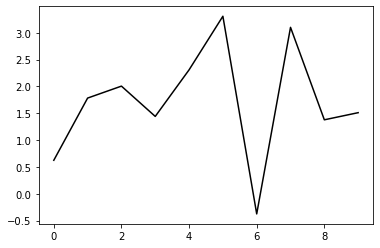

In [18]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


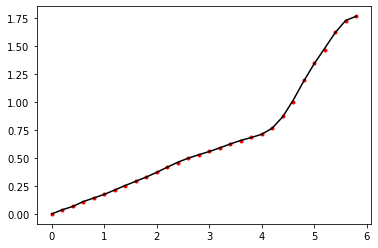

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

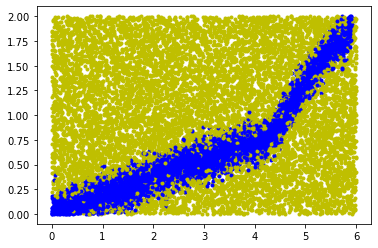

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [19]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

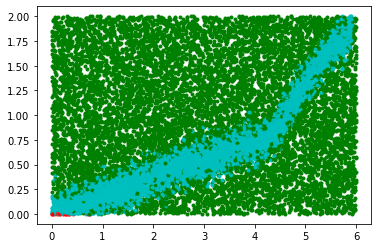

In [20]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(0.9800589184727283, shape=(), dtype=float64)
tf.Tensor(0.9682153526544738, shape=(), dtype=float64)
tf.Tensor(0.9680003861610901, shape=(), dtype=float64)
tf.Tensor(0.9738814072941968, shape=(), dtype=float64)
tf.Tensor(0.9590534826010776, shape=(), dtype=float64)
tf.Tensor(0.9763939154842941, shape=(), dtype=float64)
tf.Tensor(0.9737873755022864, shape=(), dtype=float64)
tf.Tensor(0.9306236788183799, shape=(), dtype=float64)
tf.Tensor(0.9440019400073076, shape=(), dtype=float64)
tf.Tensor(1.021605707685247, shape=(), dtype=float64)
tf.Tensor(0.9864394942940844, shape=(), dtype=float64)
tf.Tensor(0.9838194452022995, shape=(), dtype=float64)
tf.Tensor(0.9900656609767023, shape=(), dtype=float64)
tf.Tensor(1.0315608143406148, shape=(), dtype=float64)
tf.Tensor(0.9847309510690769, shape=(), dtype=float64)
tf.Tensor(0.9841542290050415, shape=(), dtype=float64)
tf.Tensor(0.94138576838506, shape=(), dtype=float64)
tf.Tensor(0.9940241006797828, shape=(), dtype=float64)
tf.Tensor(0.9

# Optimize

0 1.0150112618711649
1.9875443136547413 1.4977879489489891 -0.005516207211254365 0.3768487008097862
[ 0.67393133  1.73317613  1.95597268  1.49147992  2.25915664  3.25822391
 -0.32564849  3.0513506   1.4278239   1.56102758]


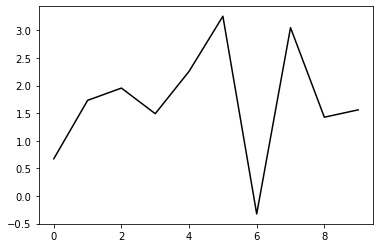

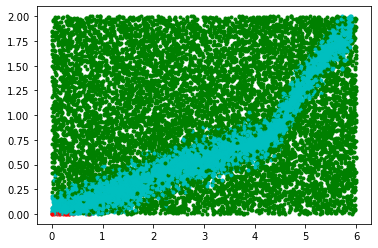

1000 1.0132469346798871
2.1273058114499737 1.2002997622665372 0.26776053545499906 0.1065538657608023
[0.1662548  0.67020808 1.21615956 1.69483494 2.03386929 2.14245567
 1.93628087 2.25837065 2.26240279 6.20681429]


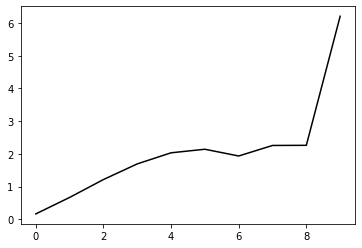

2000 0.6762617204134058
1.857710334460436 1.269009694623039 0.173406110028859 0.1603995133756507
[ 0.98931446 -0.19315826 -0.32380122 -0.23274333 -0.29803081 -0.67231177
 -1.35436657 -1.94016899 -1.80899538  9.45146485]


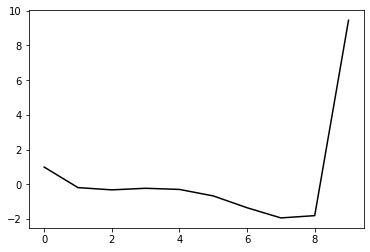

3000 0.3299844906213859
1.7992541627369503 1.1800476757976504 0.13029528282939334 0.12048607130255379
[ 0.83365679  0.10947717 -0.30770022 -0.45210365 -0.68876759 -1.24552328
 -2.17964654 -3.15929022 -3.55678857  9.37647084]


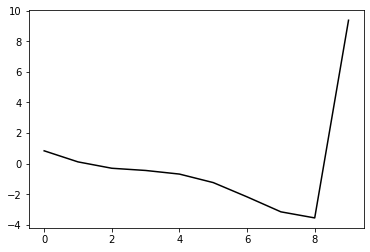

4000 0.42096780846455756
1.801878194845755 1.1424842761021605 0.10681736891870544 0.12856597994336186
[ 0.78008927  0.38557281 -0.06840193 -0.35607208 -0.66328506 -1.24371547
 -2.21460372 -3.30385433 -3.87233019  9.36018709]


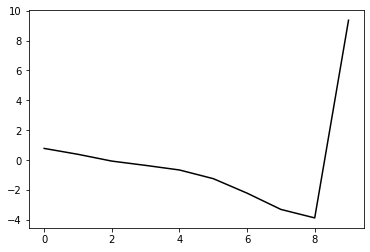

5000 0.3297545185841879
1.7888274700466649 1.0729968785270672 0.09191893760716598 0.12053325189684874
[ 0.73060928  0.50035872  0.08656706 -0.31664552 -0.73199409 -1.36632144
 -2.38833732 -3.58941468 -4.30555616  9.3422701 ]


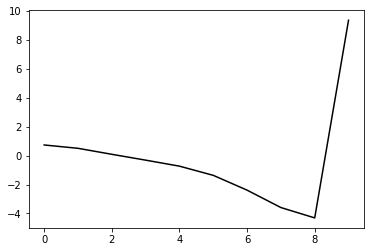

6000 0.3352260667598609
1.7749507731899237 0.9957264411173493 0.0855503765066324 0.11538361698539555
[ 0.70329156  0.53593938  0.17926829 -0.27227344 -0.779359   -1.47609749
 -2.5479717  -3.84628737 -4.68392019  9.29771009]


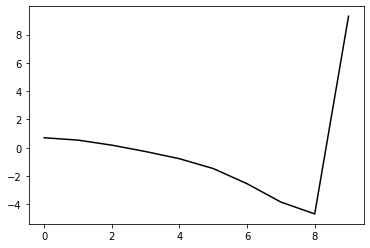

7000 0.3766226490987773
1.7861438376633818 0.9185430395254908 0.07782257879764938 0.1278444029070807
[ 0.66880532  0.54293781  0.27428708 -0.1693181  -0.73495664 -1.48260949
 -2.57856847 -3.92685973 -4.79557118  9.29838798]


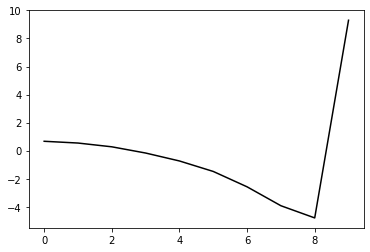

8000 0.30550086316307734
1.7931450425610593 0.8236890105131918 0.07723486237903164 0.13086467883177721
[ 0.58947813  0.63828046  0.43571771  0.02465493 -0.56225781 -1.35111689
 -2.47618489 -3.8799522  -4.81201757  9.30095197]


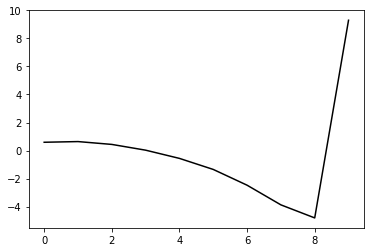

9000 0.4561542995767208
1.780010973258689 0.7261877311574026 0.07926153073930084 0.12601486767139733
[ 0.58663538  0.62778059  0.45183131  0.06953266 -0.53233968 -1.37570791
 -2.56099129 -4.06095138 -5.11648144  9.28132546]


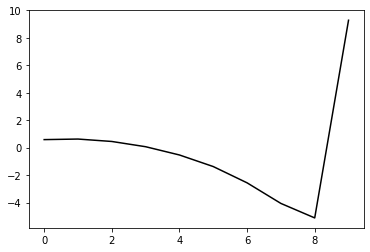

10000 0.3223337533765776
1.7625351874496402 0.5362876300797382 0.07575807110083688 0.12214988332023625
[ 0.61970953  0.57434701  0.39827466  0.02587174 -0.58413703 -1.46892241
 -2.70818607 -4.28640372 -5.43357852  9.30160043]


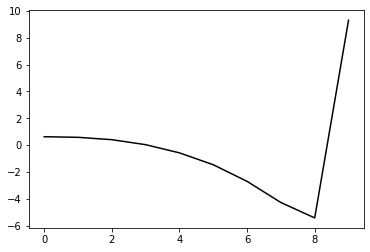

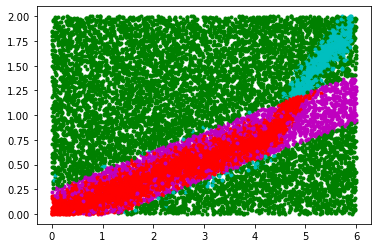

11000 0.42664296443268646
1.7623990703035228 0.3848014215558006 0.07429509665797547 0.12802327838352154
[ 0.60810934  0.6168189   0.46573783  0.11511873 -0.4836226  -1.38277055
 -2.65448953 -4.28354489 -5.47892251  9.30708349]


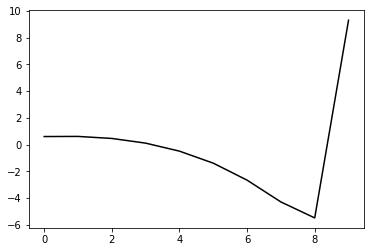

12000 0.43889650363371013
1.7604519098015756 0.23745865544650596 0.07885188735623791 0.1303163560293184
[ 0.60770191  0.62300343  0.49197404  0.15975662 -0.43526019 -1.36023975
 -2.69304448 -4.4261541  -5.75769277  9.27562307]


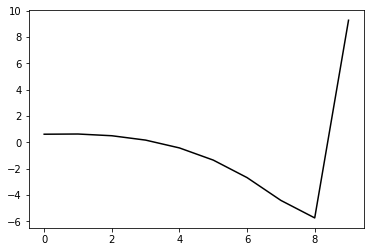

13000 0.4822956821590745
1.7624002913235737 0.14034580626417562 0.0784471657496355 0.1405963462041677
[ 0.57000212  0.72728303  0.64994199  0.36486058 -0.19322289 -1.10329285
 -2.45200696 -4.2359125  -5.64269734  9.27118695]


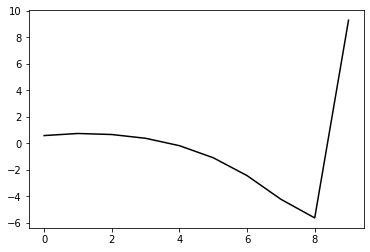

14000 0.47733703211845124
1.75423184879978 0.018734083589660635 0.07753098883404033 0.14666279774432678
[ 0.58229673  0.73548472  0.6826059   0.4252047  -0.11177284 -1.01863897
 -2.39277928 -4.2340005  -5.71023935  9.27742215]


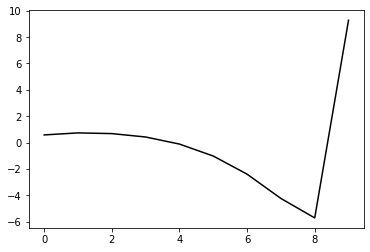

15000 0.3292508551391425
1.7382004751211468 -0.07921852204023277 0.0791852877952577 0.1497931708389501
[ 0.61262774  0.7022007   0.65911434  0.41217703 -0.11748221 -1.03423417
 -2.45220413 -4.38379736 -5.99032078  9.25237238]


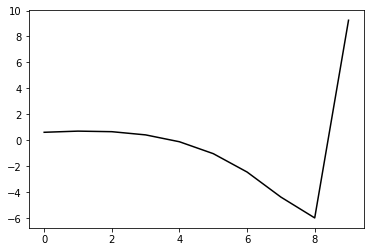

16000 0.4389402141847592
1.7259682592039094 -0.24967129143737624 0.08656864282089714 0.14370304962417313
[ 0.60264758  0.70992166  0.68361038  0.45759992 -0.05501992 -0.96774233
 -2.41174528 -4.4135508  -6.12431571  9.29022203]


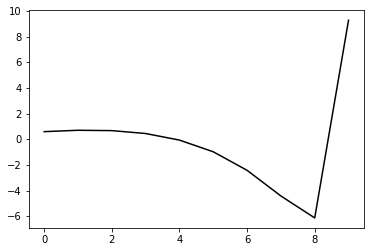

17000 0.4734478531505927
1.7082115261303055 -0.3964307348890998 0.08606464416108334 0.1488612247768845
[ 0.65167062  0.67868483  0.65498197  0.45000758 -0.03659962 -0.93280043
 -2.38834852 -4.44545082 -6.23588251  9.26233014]


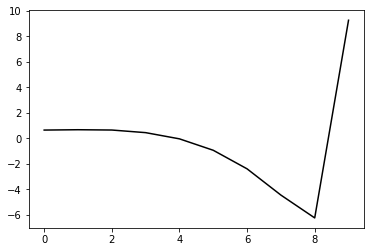

18000 0.36191242856117783
1.7121869043185927 -0.48937923636020886 0.09148965658531673 0.15643275026852624
[ 0.63135584  0.78143582  0.78365033  0.60674585  0.15596228 -0.70939299
 -2.1615811  -4.26507937 -6.13190274  9.26572007]


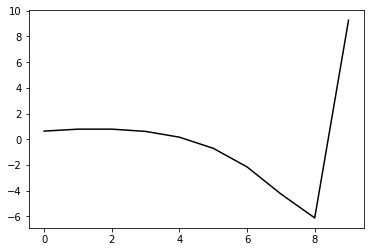

19000 0.4046000436005441
1.656857126101833 -0.67587475912999 0.10395081750216578 0.14780215156261592
[ 0.67381777  0.76282203  0.77079118  0.615923    0.19221083 -0.64671976
 -2.09808186 -4.27529197 -6.33300187  9.25137986]


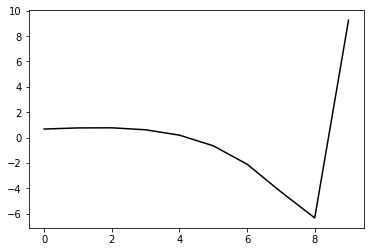

20000 0.26142640450632576
1.5291490189923664 -0.9804235358445661 0.14266710048491893 0.15834144960932597
[ 0.90032295  0.73217765  0.76753794  0.73954674  0.48730638 -0.14866807
 -1.39900746 -3.46820492 -5.62571035  9.29903577]


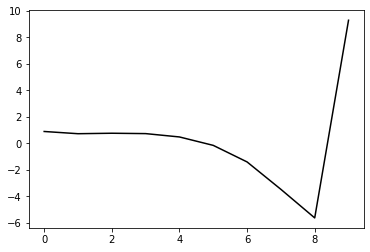

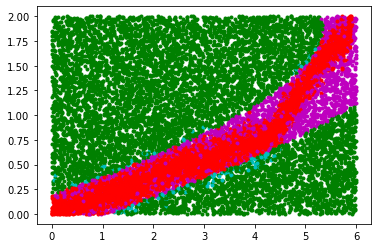

21000 0.21378162994105362
1.5224542851847556 -0.9759288183918797 0.1538230901252218 0.15362325574276525
[ 1.0178223   0.89945194  0.89822652  0.924104    0.78083174  0.27758017
 -0.83220479 -2.79578324 -4.98811166  9.31716708]


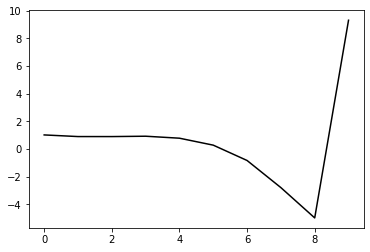

22000 0.16770729999067224
1.508182387430222 -0.9675723612865885 0.15778453564192632 0.14051541681926624
[ 1.12230273  0.95805127  0.9292415   0.9382037   0.81915917  0.36112156
 -0.70263894 -2.65628015 -4.9570993   9.31313531]


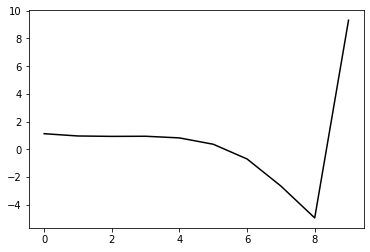

23000 0.21827512839432384
1.5166123879308178 -0.9486081125249058 0.15777422917274303 0.13034816137772404
[ 1.13447208  1.12558182  1.09717345  1.10043648  1.00515585  0.60106774
 -0.39434379 -2.2965055  -4.62464486  9.34884768]


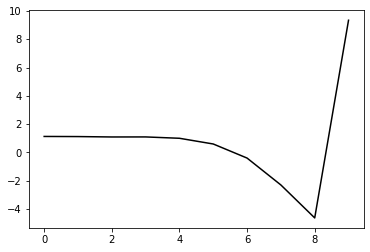

24000 0.24212917855465116
1.5104991912117502 -0.9374419564734248 0.1576002183141729 0.12460398001255914
[ 1.18124929  1.2225655   1.2026933   1.19908834  1.10984347  0.73295877
 -0.22703472 -2.11867699 -4.53641641  9.34929236]


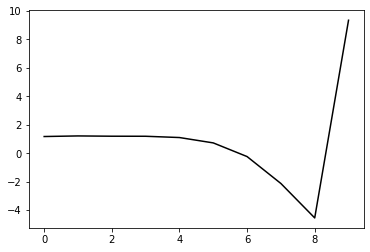

25000 0.208353751163871
1.497069716887806 -0.9277988022585368 0.15769852118249766 0.1184488900304147
[ 1.21107329  1.30575937  1.30339404  1.29987745  1.21545378  0.86016041
 -0.06947382 -1.95145127 -4.45565644  9.33295274]


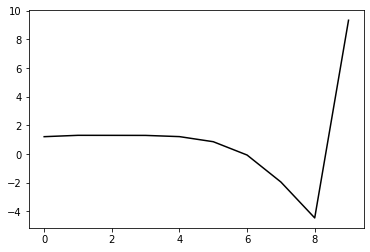

26000 0.28007931303936645
1.4763013239261114 -0.9210975921207224 0.1565437995896577 0.11561483650885664
[ 1.26162973  1.35763407  1.37091567  1.3674362   1.28370495  0.94513243
  0.0457641  -1.81998566 -4.40408875  9.33832614]


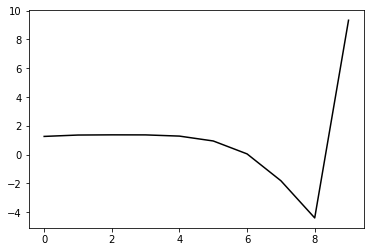

27000 0.21213387732415726
1.4474899295255559 -0.9201230639440974 0.15664670181051393 0.11138381298127178
[ 1.28659379  1.39510797  1.41711957  1.40512173  1.30537347  0.95522911
  0.04439621 -1.86740917 -4.6180178   9.32399806]


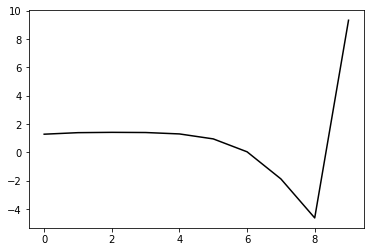

28000 0.16002847136051068
1.432240698970249 -0.9146660608822167 0.15629058978061128 0.10980111048248692
[ 1.2661106   1.49027793  1.53813888  1.5297495   1.42636657  1.08090234
  0.184415   -1.7350229  -4.59613875  9.30780684]


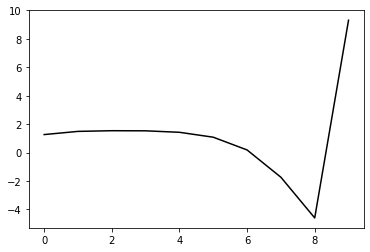

29000 0.2217967597260677
1.415577336164669 -0.907953746093787 0.15340337517404024 0.11042659007363169
[ 1.27602891  1.52876397  1.60085085  1.5949885   1.48321713  1.13194236
  0.23429796 -1.71422486 -4.69548914  9.32472895]


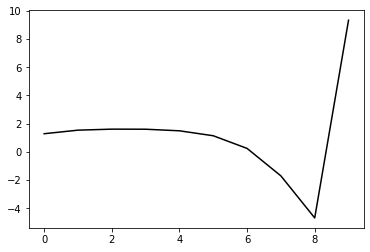

30000 0.22585588500741874
1.3834806238082593 -0.910653032801311 0.15729233092303158 0.10857533367652084
[ 1.31487177  1.52802129  1.62802812  1.64380715  1.53949678  1.19332381
  0.30470133 -1.65399033 -4.73883936  9.33851339]


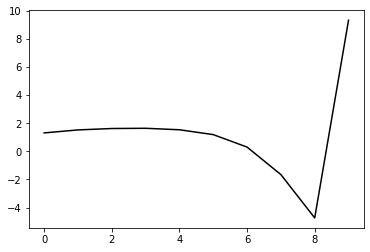

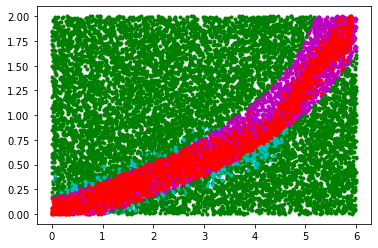

31000 0.20695981030486368
1.3714247052902548 -0.8970463430526189 0.1517212279898461 0.10606741064803261
[ 1.31487837  1.566148    1.6686061   1.6843406   1.57187043  1.212768
  0.31107154 -1.68869976 -4.91742567  9.31642768]


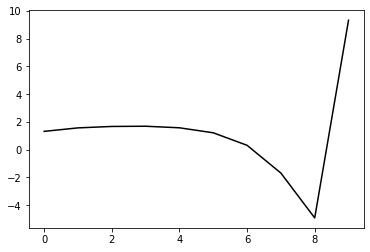

32000 0.21889894896798512
1.3510292138166136 -0.8902994734331828 0.15190926045656022 0.10194830973730026
[ 1.33302563  1.59319079  1.71002717  1.7381561   1.63333173  1.27945805
  0.38604523 -1.62138826 -4.95326063  9.3140799 ]


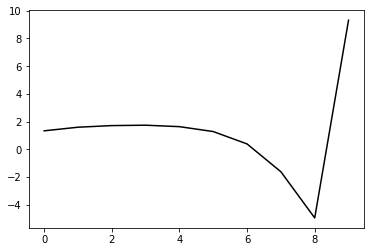

33000 0.17751378864999973
1.3347985454018272 -0.8868880169360904 0.15168593961135 0.10483376849892492
[ 1.32497729  1.63073747  1.78202595  1.82976492  1.7341637   1.38188719
  0.48795336 -1.52902416 -4.90997117  9.26077231]


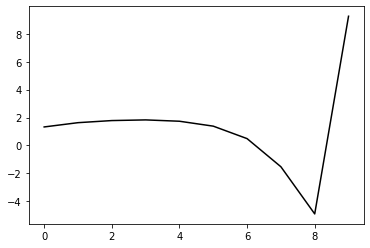

34000 0.22084728213176782
1.3131564924695271 -0.8776563552154576 0.14900514868136985 0.10099393260718653
[ 1.36038287  1.59637725  1.75891107  1.81975949  1.72804597  1.37076074
  0.46603749 -1.58118398 -5.07515391  9.2657121 ]


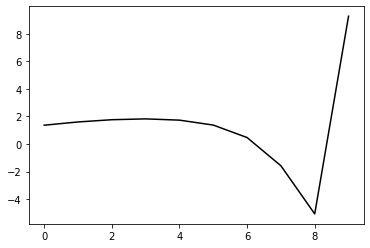

35000 0.14169356590609875
1.2984560416904845 -0.8709775663465317 0.14904930887585432 0.10179597608717182
[ 1.33501678  1.67455297  1.85953063  1.94369555  1.87362541  1.53317644
  0.64150892 -1.41006764 -4.98870853  9.28806463]


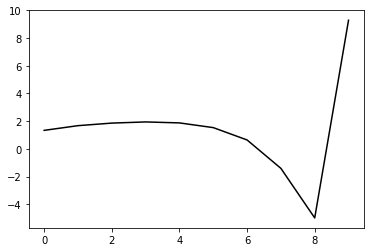

36000 0.1964797253853658
1.2728745989178654 -0.8641641638028866 0.1467012833154227 0.10024649714867336
[ 1.36163852  1.65156877  1.85032985  1.9496372   1.89179703  1.55833923
  0.67003016 -1.3888543  -5.03504484  9.3080767 ]


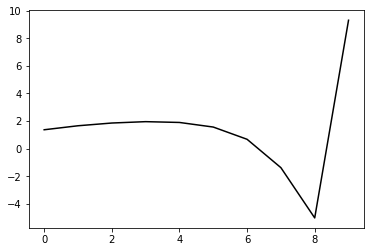

37000 0.2078841769250694
1.241654901274066 -0.8631943796219677 0.14889650929918113 0.09822545039021462
[ 1.37309251  1.67965941  1.89196971  2.0093831   1.96877084  1.64693241
  0.76161065 -1.31611886 -5.07250009  9.30490999]


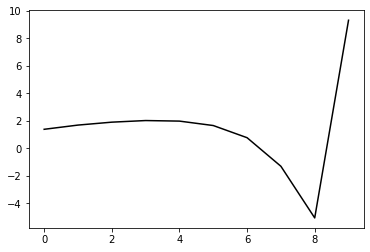

38000 0.1933246580529743
1.2166443151829192 -0.8574344341011906 0.1470827037586729 0.09854607254140318
[ 1.38369431  1.69694484  1.91692287  2.0433146   2.01266858  1.69574273
  0.80552266 -1.29607504 -5.14151155  9.28475716]


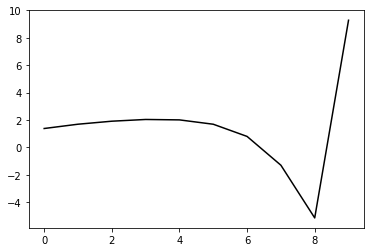

39000 0.1933790758750504
1.2017720120457285 -0.8480134333564706 0.1458012822545531 0.09834516219306608
[ 1.37908266  1.7200239   1.95111886  2.08928381  2.06881674  1.75729673
  0.86434956 -1.25336093 -5.16808605  9.28148289]


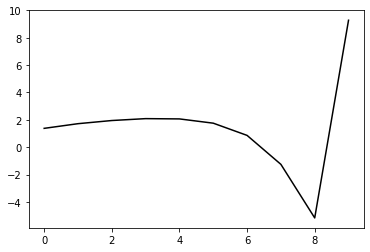

40000 0.1631998804827086
1.1888867014598143 -0.8389629457566485 0.14414259744497987 0.09787526073682126
[ 1.38893026  1.70817309  1.94701705  2.09428999  2.08358175  1.77960184
  0.88710869 -1.2480347  -5.24658921  9.29735635]


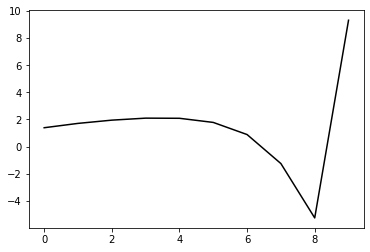

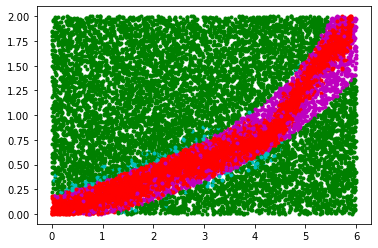

41000 0.29083150039121836
1.1630827538151245 -0.8388742531461905 0.1480650372397824 0.0972413435867028
[ 1.36286482  1.7300281   1.98069031  2.13941665  2.13868201  1.84229158
  0.95154342 -1.19422014 -5.25736885  9.33293684]


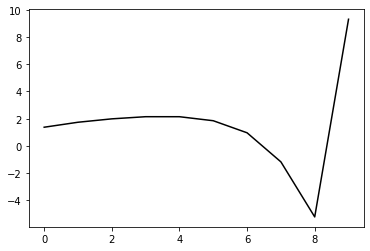

42000 0.16343192905255374
1.1285936614342873 -0.8363000931706736 0.14638540256243462 0.09767758746632961
[ 1.4076787   1.69197086  1.95728008  2.13011278  2.14473547  1.86054463
  0.97266962 -1.18728296 -5.31880363  9.29573656]


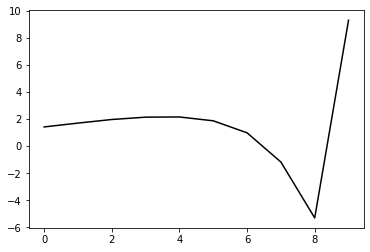

43000 0.3726773785793348
1.1035850244064949 -0.8306397665990154 0.14791433278345736 0.0948725578402791
[ 1.33914047  1.76967315  2.05259805  2.25428592  2.30222791  2.05558941
  1.20513498 -0.93302283 -5.12171762  9.30262731]


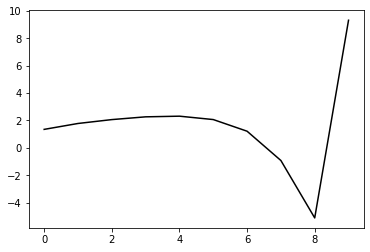

44000 0.23253913406315893
1.0737398637005484 -0.8168759066119073 0.14145982512618285 0.09582298638744424
[ 1.38791745  1.70568872  1.9677562   2.15496236  2.19008521  1.92817435
  1.05717133 -1.11594574 -5.40283169  9.29841375]


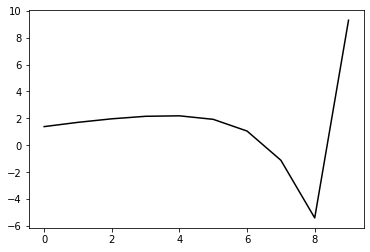

45000 0.19918587584897735
1.0452527698146237 -0.8174576849702265 0.1456358595661947 0.09474604512470766
[ 1.3522453   1.77039367  2.04340982  2.2376766   2.28048023  2.02509502
  1.15689918 -1.0228817  -5.36483966  9.29343446]


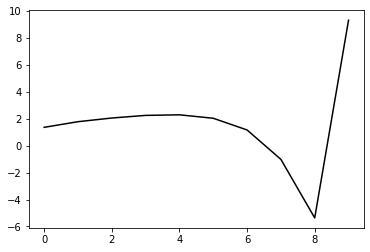

46000 0.25786915982747854
1.034856945562956 -0.8035525193850555 0.1402083030921481 0.09950476155543714
[ 1.35734813  1.7659885   2.04938527  2.23858165  2.26951155  1.99746869
  1.10851332 -1.09316765 -5.48152266  9.33635314]


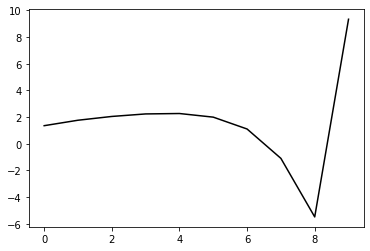

47000 0.20477105854246816
1.015722729234506 -0.8009576771456878 0.14330530220389284 0.09881267756532142
[ 1.37465323  1.77139576  2.07657268  2.29598136  2.35557164  2.10987101
  1.24150289 -0.95371838 -5.38561877  9.25103089]


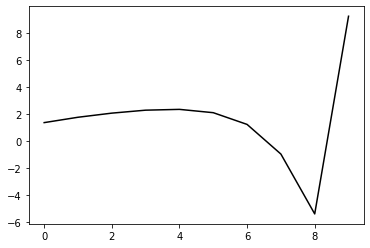

48000 0.2770966107012312
1.0079145531572988 -0.7864075426556105 0.14087504007596127 0.09807809634264637
[ 1.31821084  1.88576858  2.20366111  2.43794432  2.51619021  2.28948618
  1.43662701 -0.75692036 -5.24556109  9.27270746]


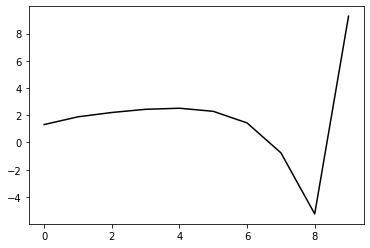

49000 0.18422651192658354
0.9730024749506683 -0.7820742025556068 0.1397566437308743 0.09852243908304396
[ 1.34916513  1.80105312  2.13668811  2.37584229  2.45491412  2.22710018
  1.36964964 -0.83807498 -5.38479068  9.28244524]


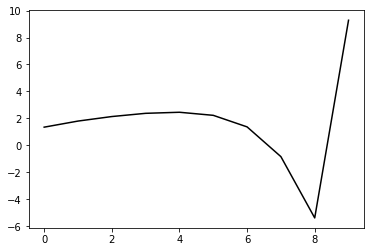

50000 0.22513345034048107
0.9554674272309032 -0.7755512550773471 0.14206708559045325 0.0975511604968967
[ 1.34009614  1.85340109  2.19907951  2.47413006  2.59985956  2.4232541
  1.61409709 -0.56448458 -5.14890822  9.30141528]


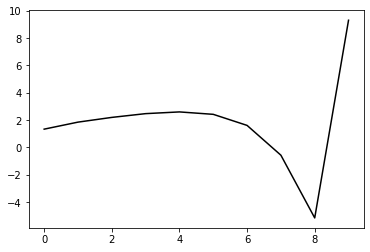

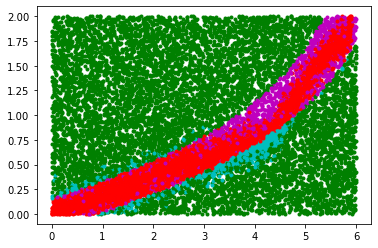

51000 0.24674618560914152
0.9210635372707516 -0.773686136106682 0.1438556898250433 0.09454107770649248
[ 1.34577649  1.7796297   2.08511495  2.32130757  2.41329639  2.21485588
  1.40031244 -0.77734434 -5.39392411  9.29396371]


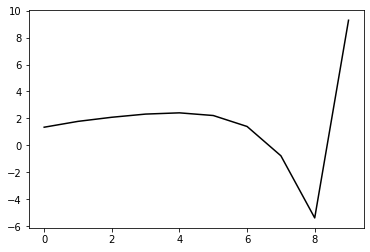

52000 0.19985063105254827
0.9071088638532503 -0.7595981840226548 0.13749081756000592 0.09640428093028425
[ 1.3540074   1.72954193  2.03844792  2.26621119  2.34921767  2.14371667
  1.32537793 -0.85644842 -5.51510538  9.30614497]


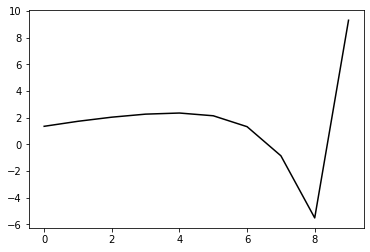

53000 0.25642557187515574
0.8916090139175836 -0.7581519390278552 0.14173859648522155 0.09866187289138449
[ 1.35572712  1.71764156  2.04046418  2.29294471  2.40073219  2.22540064
  1.44741198 -0.68915383 -5.3355015   9.30083892]


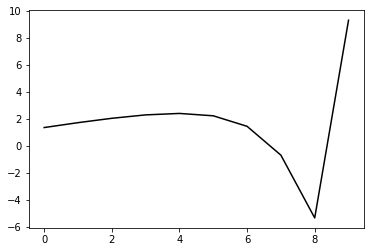

54000 0.20231126946222455
0.8871257800010866 -0.7466050259727434 0.14134789126047775 0.09914409144609027
[ 1.31015411  1.78155297  2.10402382  2.35288215  2.45958955  2.28344794
  1.5098555  -0.61586228 -5.2833404   9.28925225]


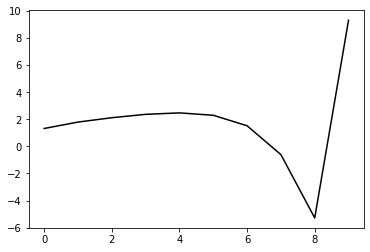

55000 0.324465763719168
0.8646851213167174 -0.7404704699045389 0.1418336004716059 0.09913571745896482
[ 1.30699536  1.75695675  2.05907012  2.29465783  2.39312343  2.21260722
  1.43733626 -0.69095603 -5.39795667  9.29698361]


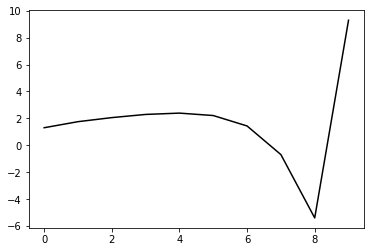

56000 0.22700843813928476
0.8451827236127254 -0.7320762066425953 0.1408953831764942 0.1001750050139472
[ 1.32323874  1.74268179  2.07063358  2.3320889   2.45746837  2.30403064
  1.55015284 -0.57029921 -5.32559793  9.28238776]


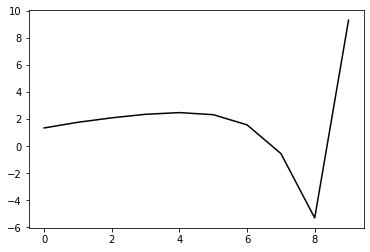

57000 0.25234173315433495
0.8308198469009742 -0.723171417212099 0.141819250156302 0.09696477611396272
[ 1.28717339  1.75917133  2.08111816  2.33679378  2.46133616  2.31636714
  1.58073146 -0.51942185 -5.28787409  9.29991814]


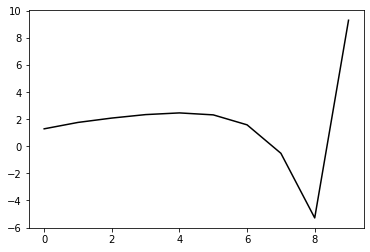

58000 0.2617768668896596
0.808141822354682 -0.7154297636322116 0.1427314411443234 0.0988766335224745
[ 1.32079905  1.74189234  2.07333474  2.34962319  2.50045052  2.38456933
  1.68064304 -0.39085852 -5.16902715  9.29794286]


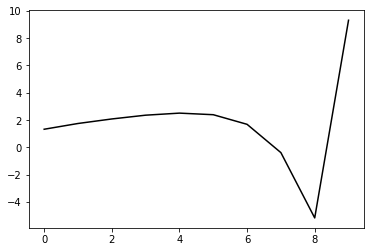

59000 0.2029397081974705
0.7900319828582688 -0.7036313625015876 0.13957671989162543 0.09575174574807478
[ 1.35110716  1.6993685   2.02063408  2.2879549   2.43667177  2.32765309
  1.64044038 -0.40993632 -5.20053826  9.32725716]


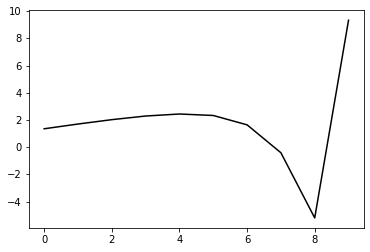

60000 0.33479634576887696
0.7701656716485165 -0.6967756840019108 0.14265311478924986 0.0958075895357253
[ 1.31228974  1.77296121  2.09273816  2.37746113  2.55771679  2.48931889
  1.84580682 -0.16873293 -4.97736203  9.31805013]


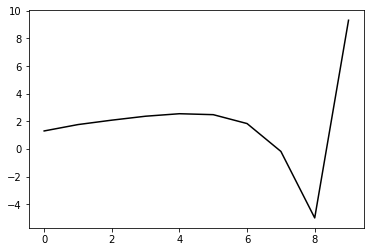

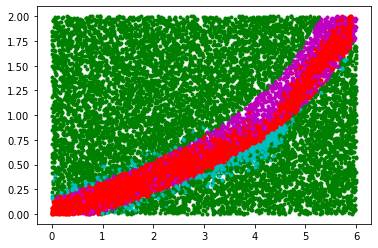

61000 0.2736785245268671
0.7541138105722902 -0.6837752044042976 0.13989239387026314 0.09331427313662878
[ 1.34721027  1.71137098  2.00205562  2.25822939  2.42085773  2.35368793
  1.73198346 -0.24757437 -5.04787845  9.27929762]


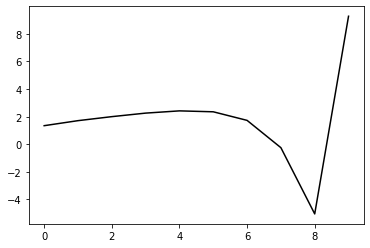

62000 0.15986801441224532
0.7092331039098686 -0.6795420493638633 0.13972530959218685 0.09437075982960899
[ 1.40601474  1.623076    1.91096997  2.16494603  2.33036083  2.27663623
  1.67595539 -0.28761875 -5.12365582  9.30205576]


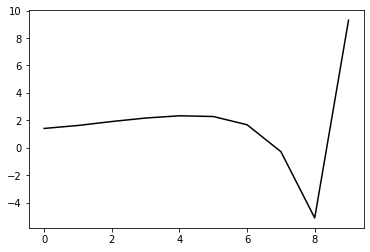

63000 0.20940528020943475
0.6911648333362689 -0.6743933568373217 0.14020108581939505 0.09123813822244556
[ 1.37158349  1.59130089  1.87122803  2.10127755  2.2371167   2.16124582
  1.55789742 -0.38916706 -5.22345127  9.30185076]


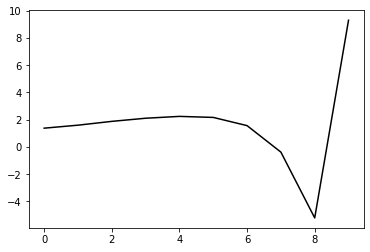

64000 0.17334231715502355
0.6948997217220502 -0.6621776358703204 0.13996268270275788 0.09479770533593948
[ 1.31289327  1.72022601  2.02760454  2.28658844  2.45305126  2.41127957
  1.85109857 -0.04755427 -4.86773938  9.31307039]


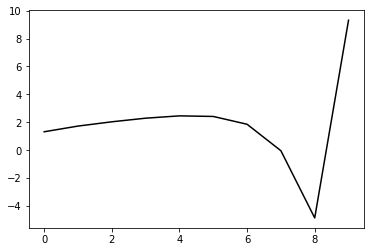

65000 0.29193079507729264
0.6870640017352894 -0.6501836175384167 0.14021975757493307 0.0922570541463325
[ 1.30575109  1.74638825  2.03440917  2.28925619  2.4601456   2.43379978
  1.90904976  0.0615234  -4.73553951  9.31532618]


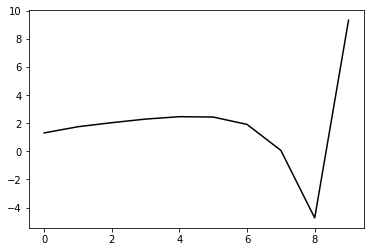

66000 0.21670964722235306
0.6457597129054414 -0.6481510128038364 0.1407743431017078 0.09579246628493766
[ 1.33455317  1.63153099  1.90200531  2.11650231  2.24158723  2.1760964
  1.63071934 -0.21284435 -5.015044    9.30422567]


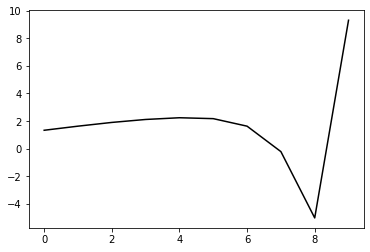

67000 0.22860330208274682
0.6327396614542743 -0.6390775991167438 0.13997989133796515 0.0952248907173273
[ 1.31907693  1.63328554  1.93366197  2.17353517  2.3055835   2.2350529
  1.68569223 -0.14863942 -4.95987855  9.30836269]


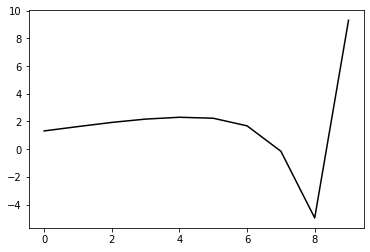

68000 0.18731469893899907
0.6251811832450892 -0.6254093880191087 0.13686850435093983 0.09414312945447181
[ 1.30329901  1.57536689  1.8346115   2.07414576  2.23071175  2.19068254
  1.67383957 -0.11977419 -4.90864184  9.35829813]


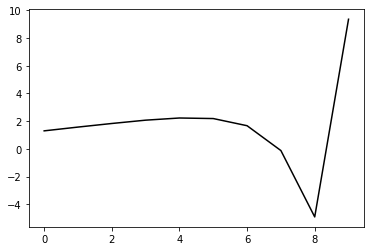

69000 0.24229737193183404
0.6165335230989185 -0.6162784279089417 0.1365659104303428 0.09489023032324671
[ 1.27812397  1.61712409  1.86574926  2.08383195  2.22507213  2.1778936
  1.66193628 -0.11437143 -4.89598651  9.3441244 ]


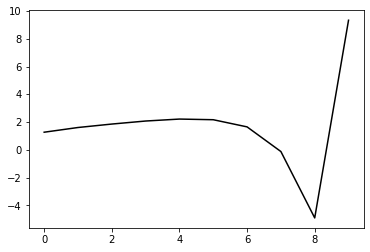

70000 0.2351758367461206
0.6039933133589199 -0.6153007128273584 0.14176030109923501 0.0918369312821621
[ 1.29197097  1.60730602  1.89004729  2.13556859  2.29699992  2.27106723
  1.77914     0.03613197 -4.72481198  9.28677542]


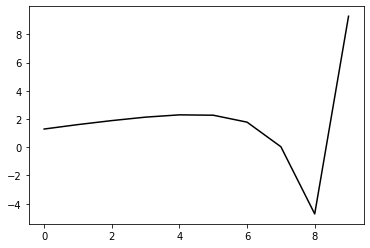

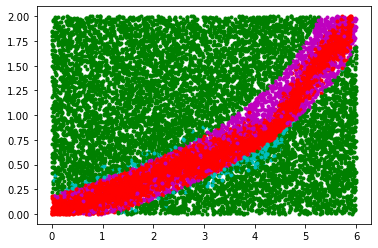

71000 0.19968053433792682
0.585497451324061 -0.6055863526865146 0.13961519108734716 0.0963154113569107
[ 1.27265511  1.52722179  1.77178867  1.97683407  2.10523441  2.0605741
  1.5701975  -0.14908619 -4.88504752  9.30181103]


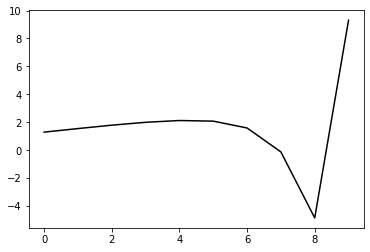

72000 0.12028264421889323
0.582540456948849 -0.5961806728238078 0.14039469909442734 0.0963195082975154
[ 1.2726898   1.61922609  1.91183487  2.1452882   2.28711045  2.24509084
  1.75382459  0.04002136 -4.69665074  9.37132456]


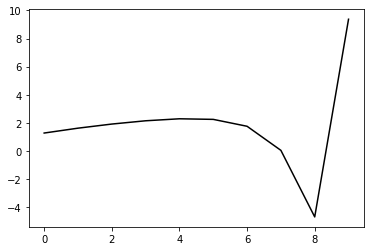

73000 0.211432683564081
0.5634943404306721 -0.5936828690452709 0.1438045696585996 0.09747203335337032
[ 1.28435934  1.53974635  1.79826737  2.02911859  2.18523588  2.16676512
  1.70627554  0.03312807 -4.66566057  9.30733937]


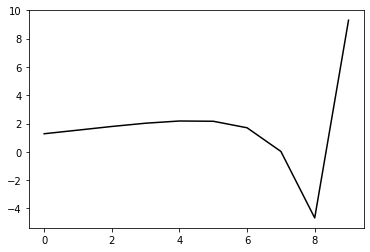

74000 0.21541529312594623
0.5739951056485039 -0.5770498455180407 0.13974885641958223 0.10096097719152757
[ 1.24212686  1.6445508   1.91792923  2.12321729  2.24581073  2.1982396
  1.72017233  0.04603904 -4.65077822  9.26062332]


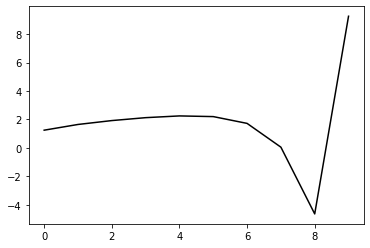

75000 0.19734401575449104
0.5573247400651309 -0.5698732067490692 0.1400437310763727 0.09938017151786421
[ 1.23613566  1.56636898  1.83276497  2.06356434  2.21543547  2.18868929
  1.72622589  0.07109268 -4.61572104  9.31837258]


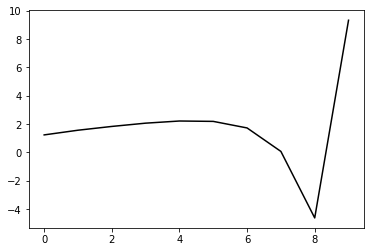

76000 0.19220832931046625
0.5423176532599658 -0.564892335303153 0.14257997620427423 0.10070494513555175
[ 1.22904229  1.56925874  1.82720958  2.07055468  2.24326211  2.24047954
  1.80142237  0.17331987 -4.49391162  9.32779519]


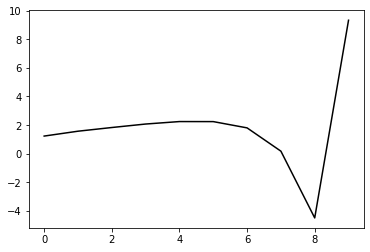

77000 0.18428419057213902
0.5289019576975371 -0.5532233096610342 0.13879791685896434 0.09933823300426897
[ 1.21559269  1.46277664  1.68452519  1.88463566  2.0256797   2.00600004
  1.55973474 -0.06461508 -4.72451457  9.34163598]


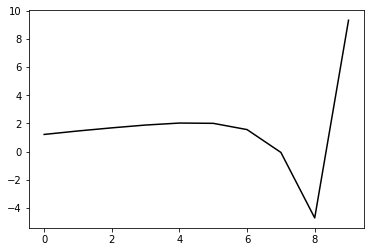

78000 0.21112300167733344
0.5170821837891588 -0.5499407462988282 0.14022703727920108 0.10150871562298962
[ 1.19681121  1.54506087  1.79686952  2.0087651   2.15169365  2.13226738
  1.68835739  0.07222571 -4.5761663   9.33002737]


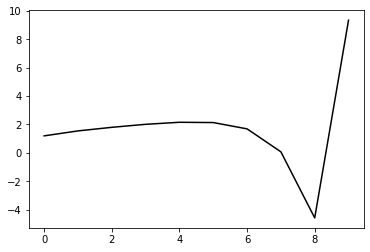

79000 0.21624481490930092
0.49502215803270283 -0.5450263020801049 0.1398691264708043 0.10073371782971655
[ 1.20059775  1.43112581  1.66445161  1.87849053  2.02772609  2.01599268
  1.58336945 -0.01625048 -4.6483016   9.34358205]


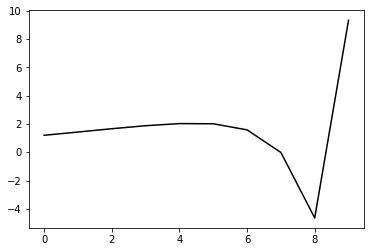

80000 0.15579270834516162
0.49299788384859955 -0.5360180889337118 0.1400437827033719 0.10357033180282317
[ 1.19665154  1.5020114   1.76335304  1.98280587  2.13113434  2.11738842
  1.68603709  0.09579122 -4.52104254  9.32246313]


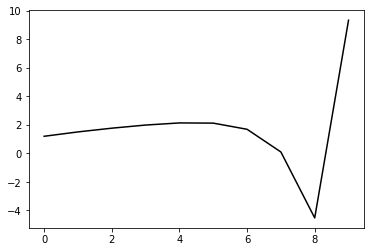

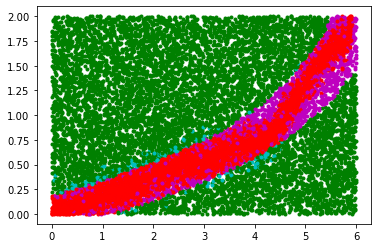

81000 0.23835705591602133
0.4870530325908614 -0.5294186795203644 0.1419771092008566 0.10377828920619368
[ 1.17621593  1.46314042  1.7032282   1.9284341   2.09594709  2.10692108
  1.70371472  0.14636768 -4.43463122  9.3347758 ]


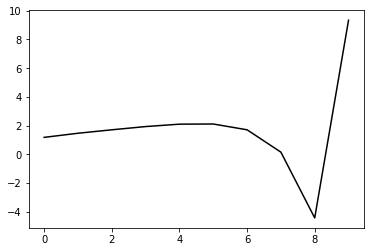

82000 0.2109511051273711
0.47727260541701383 -0.5227017911787635 0.1451807393607502 0.09999193681336144
[ 1.1889535   1.47518525  1.70149662  1.92177969  2.09742074  2.12106411
  1.73136805  0.19043584 -4.37510372  9.38570355]


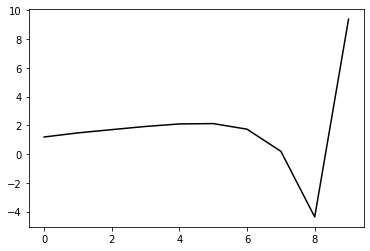

83000 0.10960337200995802
0.46855438244095976 -0.5119737556012848 0.14279957026156062 0.1023692647292348
[ 1.20134862  1.45185947  1.68192447  1.90981323  2.09722306  2.14099198
  1.77503764  0.2600615  -4.27783702  9.33293767]


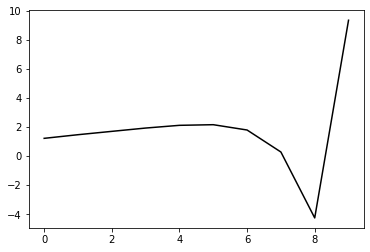

84000 0.15723321631867918
0.4669902945910111 -0.5036281697543921 0.14281584464900407 0.10493356255407645
[ 1.16480253  1.44052225  1.64859422  1.84977435  2.02023993  2.06156492
  1.70456337  0.20612631 -4.30769569  9.32045941]


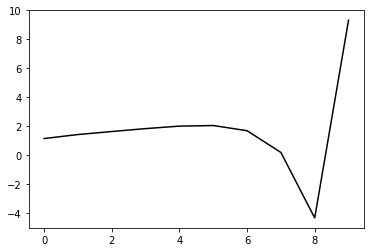

85000 0.18651774921985995
0.45963754159064674 -0.4946928254844694 0.14292674312071885 0.10275403280781056
[ 1.17033517  1.4324837   1.63136084  1.82465441  1.99137707  2.03637972
  1.69346563  0.21590947 -4.27458114  9.30074356]


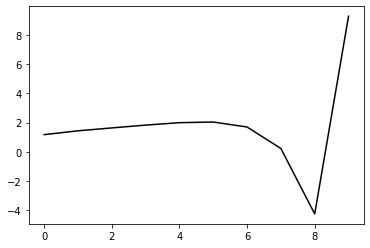

86000 0.22011146001514428
0.4533537252967032 -0.4899681370697294 0.14604296451719948 0.10265542903838973
[ 1.174028    1.50506005  1.69017377  1.8804556   2.05188078  2.11007359
  1.78840364  0.33714436 -4.12466404  9.34809617]


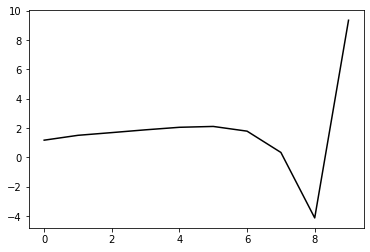

87000 0.1622333997673291
0.44364295125359887 -0.48386597581335544 0.14807968339196442 0.09996209809340752
[ 1.16562248  1.49894278  1.71306289  1.90611375  2.07079956  2.12507937
  1.80918008  0.37283138 -4.07036562  9.37122297]


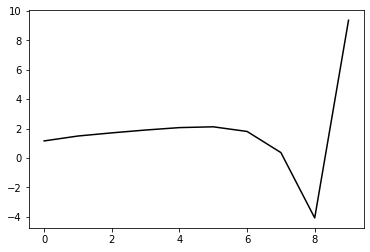

88000 0.19336462802559676
0.43602014880105194 -0.47461134790573095 0.14659593822068942 0.10128408647217875
[ 1.16858743  1.50345698  1.71135777  1.89978487  2.05309685  2.09768308
  1.78375142  0.36308759 -4.05453369  9.34833531]


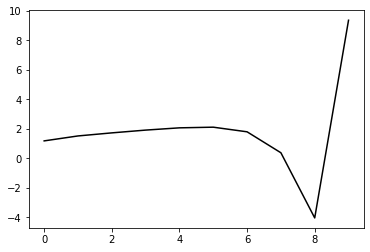

89000 0.273212159702096
0.42086887257518396 -0.47696157881760504 0.15073640856812218 0.09912984365674685
[ 1.15003406  1.42538301  1.62555659  1.81045188  1.96467378  2.01163186
  1.70884868  0.31372832 -4.06444167  9.30403356]


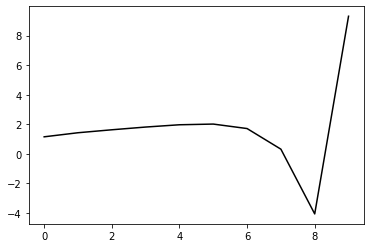

90000 0.24180486938484272
0.4174412763734599 -0.4654836189871553 0.14803859801811042 0.10025125324001681
[ 1.14217516  1.51575464  1.72042453  1.89207613  2.02228079  2.03961903
  1.71218257  0.30800382 -4.06675188  9.32577104]


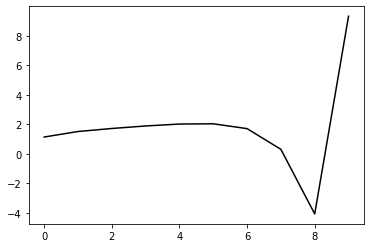

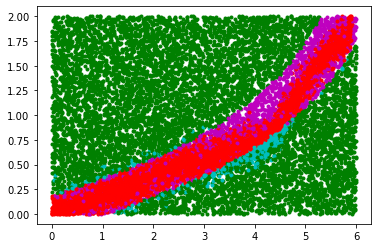

91000 0.1863537118746317
0.4166362831545452 -0.45457365997773513 0.14551849138765627 0.10303030741275421
[ 1.1734427   1.4957262   1.69523627  1.86161817  1.98039016  1.98575709
  1.65430564  0.26364057 -4.0786639   9.3418739 ]


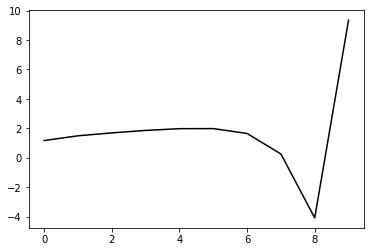

92000 0.1361133226128151
0.41158232311869547 -0.4532422654133994 0.14884750920175038 0.10555678177954778
[ 1.15002076  1.50250616  1.69597776  1.86825155  1.99205235  1.99615051
  1.66328582  0.28279887 -4.03457745  9.31792258]


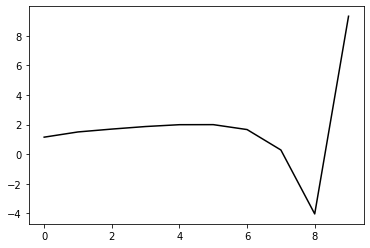

93000 0.244280326852588
0.40323531131715856 -0.45033671026436245 0.15182247712735716 0.10249159697667251
[ 1.15887899  1.44364856  1.6510855   1.83491265  1.96879461  1.97922129
  1.64946418  0.27996878 -4.01427023  9.31507203]


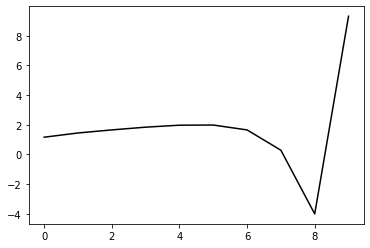

94000 0.15814156483906502
0.39624183638712984 -0.44877075856337595 0.1536178518886839 0.1068631303596179
[ 1.15599574  1.37333341  1.58339135  1.76700034  1.89402697  1.89613059
  1.55980993  0.1965721  -4.07006069  9.35003266]


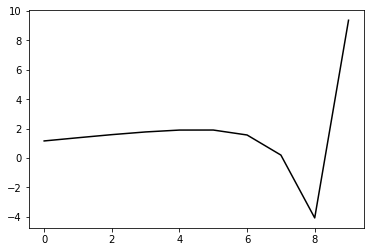

95000 0.1577566035296344
0.4034087316952437 -0.43514347089784144 0.15022632386169515 0.10560382143874503
[ 1.15828137  1.43448139  1.65666734  1.84791746  1.98485924  1.99207061
  1.6567702   0.30068954 -3.94428035  9.35173259]


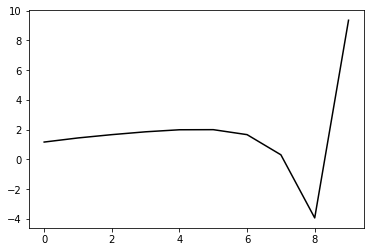

96000 0.23901695505214518
0.39539107646889493 -0.43393830897215 0.15482055821551577 0.10588878372387263
[ 1.13912586  1.45845125  1.66393568  1.84932515  1.98186529  1.98555503
  1.64619233  0.29188899 -3.93857081  9.36253046]


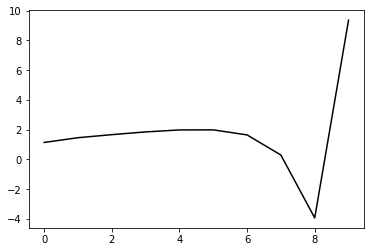

97000 0.17286819505420695
0.39343559569071446 -0.4236631969098864 0.15234514700196478 0.105246646106149
[ 1.12808644  1.49538032  1.73330457  1.90266518  2.00870841  1.98288769
  1.6133385   0.23534979 -4.00427135  9.38492195]


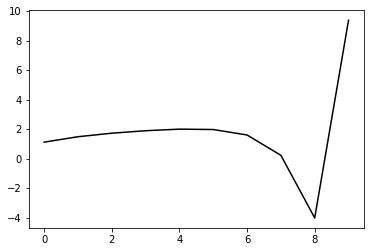

98000 0.23180916942068
0.3821533951987789 -0.4242386787724294 0.15531118321279724 0.10584368992276313
[ 1.13929377  1.43929827  1.64560144  1.82720336  1.94841302  1.92818253
  1.55837242  0.18366457 -4.03660128  9.35533221]


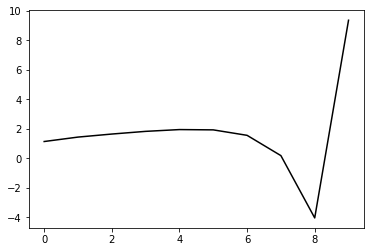

99000 0.20167510451428608
0.3726980542939909 -0.4191808951170841 0.15453020562758668 0.10283801681980481
[ 1.18270033e+00  1.29359486e+00  1.50624086e+00  1.67514805e+00
  1.78276609e+00  1.75248824e+00  1.37314037e+00 -5.42887713e-03
 -4.21222015e+00  9.34423061e+00]


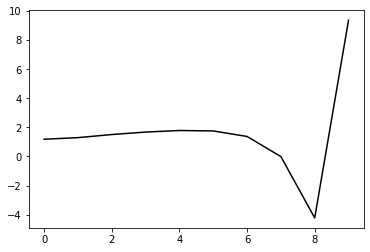

In [21]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.4984838800742739
0.39518721095000464 -0.41279886483700007 0.15961076187568032 0.09942333049935
[ 1.10306147  1.575091    1.81209163  2.00924742  2.13528939  2.11425989
  1.73788699  0.363406   -3.82161163  9.34007406]


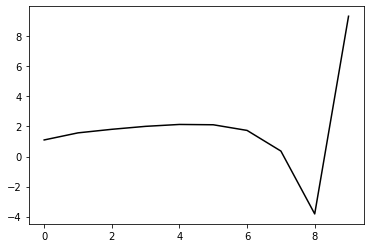

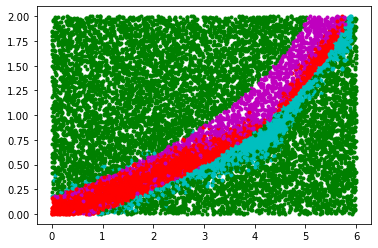

1000 0.22425449168165995
0.38279539296671306 -0.39792239063886864 0.15327207450396693 0.11038705090831409
[ 1.11104322  1.4135684   1.62718899  1.8065887   1.91754172  1.8799359
  1.48611564  0.09913767 -4.08053041  9.33710012]


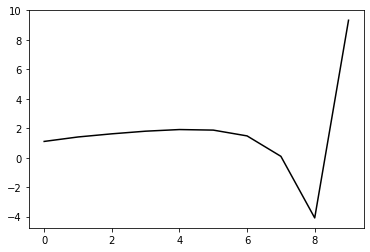

2000 0.26812746944324034
0.37799735617148605 -0.3955103344536661 0.15647684190025166 0.10967192690346583
[ 1.11369797  1.43427161  1.65457009  1.81949795  1.91052442  1.85066733
  1.43329276  0.02864089 -4.1460045   9.33023623]


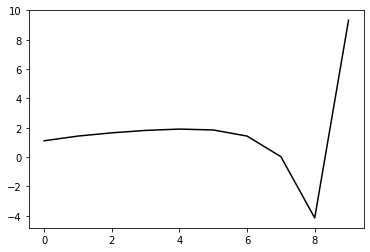

3000 0.22118082955278512
0.37319138118827005 -0.39291434626076416 0.1591767737269403 0.10888203811683109
[ 1.1455056   1.42376616  1.65804088  1.83937118  1.94627918  1.89665529
  1.48323116  0.08210731 -4.07252216  9.32985191]


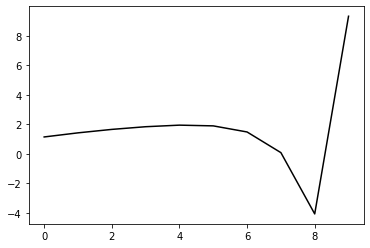

4000 0.1752284087407847
0.37375766215619477 -0.3830888450286078 0.15717472928117096 0.10841503977869356
[ 1.13777217  1.40283913  1.622457    1.81868533  1.94361051  1.90944206
  1.50508503  0.11115236 -4.01985049  9.34968738]


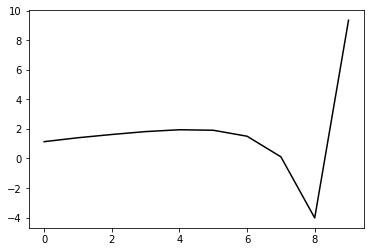

5000 0.16517686672039292
0.3765583266625744 -0.37862409714170603 0.15943527804574537 0.11060778684400742
[ 1.11292164  1.44473612  1.6517533   1.83542293  1.967746    1.95034034
  1.56088187  0.18059521 -3.91737997  9.39789931]


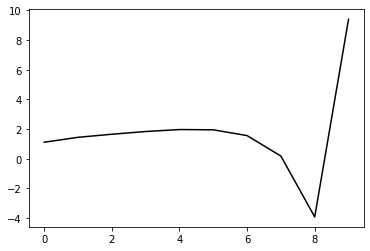

6000 0.254841525952567
0.37207097519447907 -0.3726260389708844 0.16031954325311623 0.10686802279653226
[ 1.0982978   1.42378219  1.63129698  1.81090366  1.94162632  1.93232727
  1.55289039  0.17917705 -3.8990162   9.37136934]


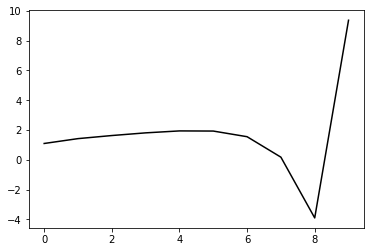

7000 0.2380605766811393
0.36643958602748006 -0.36871100417740554 0.1619885513849024 0.10864216800742989
[ 1.13031699  1.38271161  1.56862859  1.74713837  1.88771896  1.8949661
  1.53586082  0.18056646 -3.86461848  9.35222059]


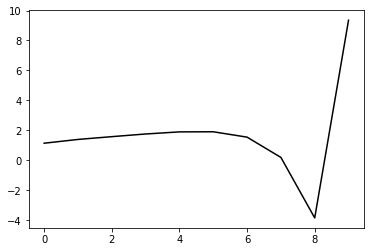

8000 0.17208348987272595
0.35708618008681975 -0.3652738514586827 0.16290073116661696 0.11016500667866248
[ 1.14107797  1.30192387  1.47108181  1.64875621  1.79095415  1.80751277
  1.46312312  0.12183537 -3.89568098  9.3826393 ]


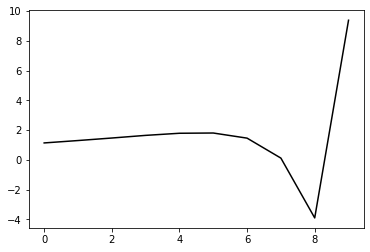

9000 0.21960250001679565
0.35599512271941425 -0.35890391202223204 0.16363916964274328 0.1121778129109705
[ 1.12961608  1.34342011  1.51274191  1.69453907  1.85101722  1.88781126
  1.56618763  0.24470839 -3.74544818  9.35917409]


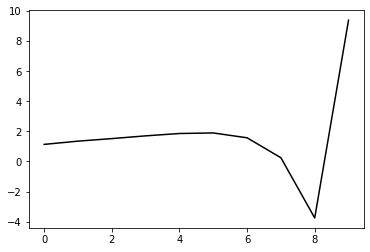

10000 0.22540381990458572
0.353143105338721 -0.3508273419354772 0.16347680612881596 0.10727235842432319
[ 1.12347198  1.35395446  1.52163261  1.68459037  1.83413203  1.87685904
  1.56885134  0.26133053 -3.70609245  9.36622912]


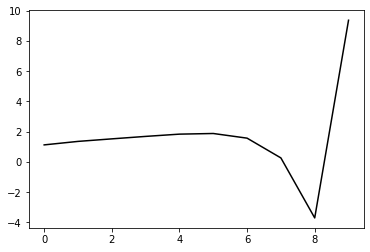

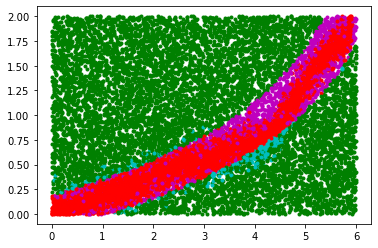

11000 0.17247410601964827
0.34777761639086546 -0.3464209542669741 0.16558024906468002 0.1068811485856971
[ 1.13634737  1.33950111  1.48698108  1.63745935  1.77778514  1.82387054
  1.53197112  0.24507251 -3.68971389  9.39325472]


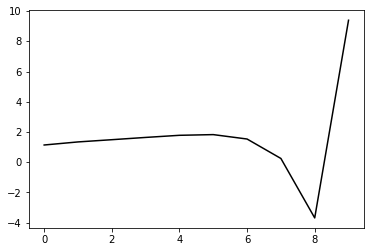

12000 0.2619032912071505
0.34703940628012453 -0.34138317874036805 0.16554875882109818 0.10784626129207703
[ 1.11095613  1.35095963  1.52819068  1.66966427  1.77659747  1.7914634
  1.48711664  0.20326482 -3.70736561  9.38932038]


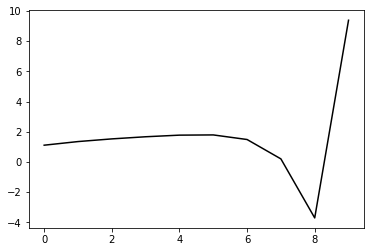

13000 0.19392828060644382
0.33878006889441287 -0.3341997409172858 0.1623501018270191 0.11275188645263175
[ 1.13574498  1.34657456  1.53045059  1.66102055  1.74621718  1.73155024
  1.40527729  0.11296402 -3.78771131  9.3594658 ]


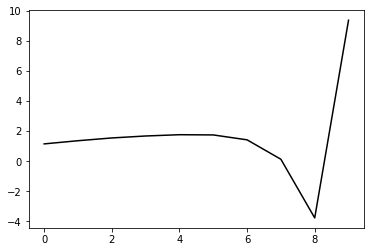

14000 0.24362594398487405
0.3411515001791625 -0.3274481071399201 0.16331985943028623 0.10879355316737302
[ 1.05989555  1.31708104  1.47578495  1.60936478  1.70321337  1.68622563
  1.35771276  0.07495966 -3.79892174  9.36435225]


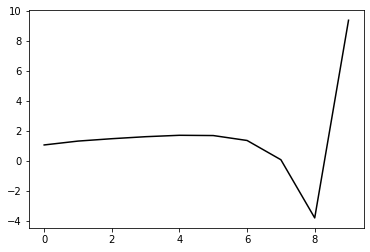

15000 0.17212065414471392
0.33407650923178284 -0.3294722536846313 0.16820416808291838 0.11365986253343595
[ 1.10830358  1.37870148  1.52997976  1.68016142  1.79763594  1.80169571
  1.48908617  0.22919188 -3.60401173  9.38275233]


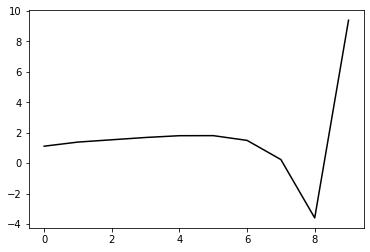

16000 0.20952699260294763
0.33261607229263424 -0.32291959336421017 0.16761965968874548 0.11098827906404996
[ 1.09917727  1.39240332  1.57160695  1.69374468  1.77299131  1.74625708
  1.4092068   0.13801697 -3.68448016  9.35652318]


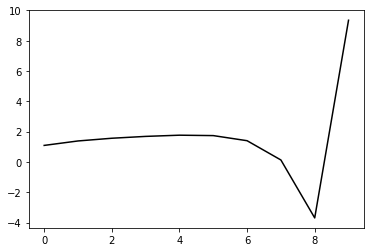

17000 0.24434491996379976
0.3314093511009874 -0.32410768218133174 0.1727568586197143 0.10865811252987104
[ 1.14111404  1.2475776   1.42837971  1.58753368  1.69490689  1.68676115
  1.36770487  0.12216289 -3.65341317  9.36281052]


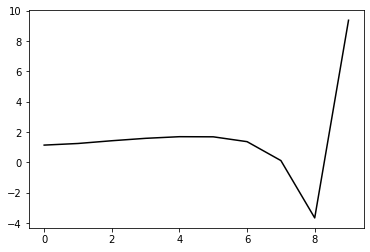

18000 0.18804280569568643
0.33167745829782797 -0.3142827535657694 0.17105564626689967 0.10919477810474053
[ 1.1399449   1.37443853  1.54442472  1.70591554  1.82112687  1.81468348
  1.49154105  0.24538407 -3.51756702  9.40575336]


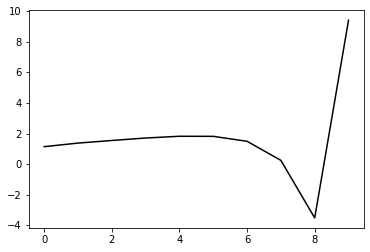

19000 0.19836419328010702
0.3267740979757937 -0.30925416227445596 0.17164329399371994 0.1070680010437276
[ 1.14744137  1.35647486  1.51976475  1.66990528  1.77858088  1.76967761
  1.44312103  0.19878886 -3.54373731  9.37344952]


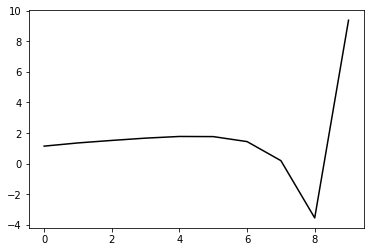

20000 0.23001123423190198
0.3224978475706053 -0.3092498540554028 0.17415812726361793 0.10351128108872933
[ 1.16292139  1.2867794   1.45621536  1.58507718  1.6683951   1.63894612
  1.29696932  0.04714452 -3.6753835   9.37607436]


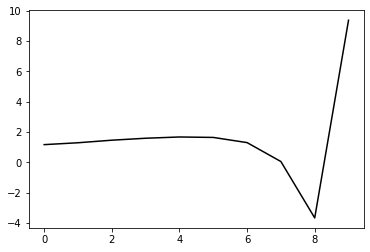

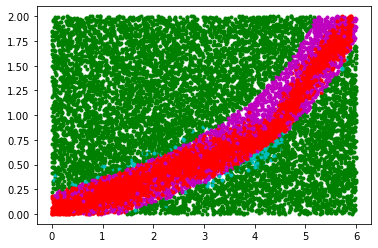

21000 0.23791990869297264
0.3142348746607828 -0.3101361222602174 0.17553218044290086 0.10922924417004679
[ 1.14273018  1.13940311  1.29303094  1.43454676  1.52561074  1.50033684
  1.16574067 -0.06753797 -3.74605037  9.37804908]


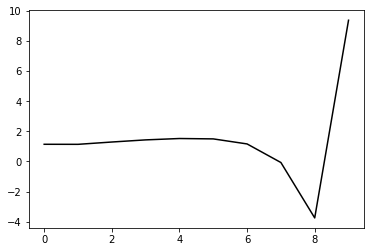

22000 0.15949825673606868
0.333769771066755 -0.2939150698658396 0.17087179312061632 0.11432936587779177
[ 1.09259908  1.41701364  1.5795246   1.69312859  1.74763074  1.68451228
  1.31616935  0.06010494 -3.61654911  9.3948774 ]


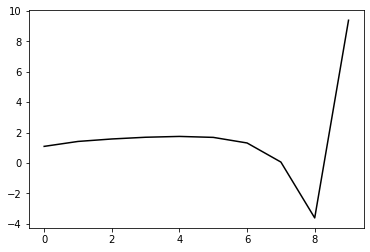

23000 0.23269256746991762
0.325024541484705 -0.29607567143583635 0.17426933175360537 0.11388949964040082
[ 1.07703361  1.37708035  1.55990056  1.70811821  1.78946858  1.73932187
  1.37660385  0.12814937 -3.52388335  9.3715549 ]


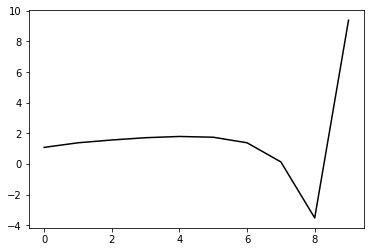

24000 0.22212744775302765
0.32436462345784817 -0.28778507510444 0.17161123820117302 0.11770891911348362
[ 1.07507669  1.34314557  1.51007385  1.64741546  1.72450728  1.67077778
  1.30143136  0.05047614 -3.58453768  9.35649275]


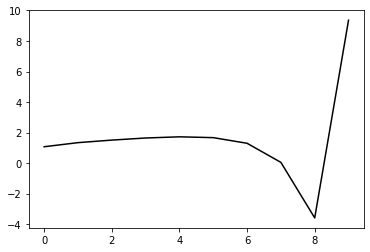

25000 0.1640191694494439
0.3184645228701443 -0.28630931071845217 0.1734351229489713 0.11679643408355639
[ 1.10439578  1.35955063  1.51744269  1.64950289  1.73241299  1.68463245
  1.3152883   0.06526082 -3.54871982  9.35332061]


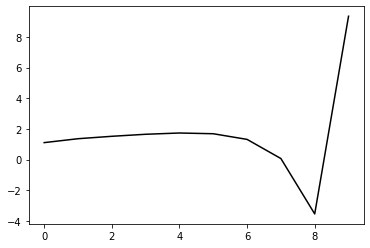

26000 0.35698414587332605
0.32173916372887384 -0.28169149964782625 0.1752142978263464 0.11441765759895602
[ 1.05673156  1.40215427  1.57562716  1.70852824  1.78831936  1.73875394
  1.36483012  0.1105302  -3.48863797  9.41312653]


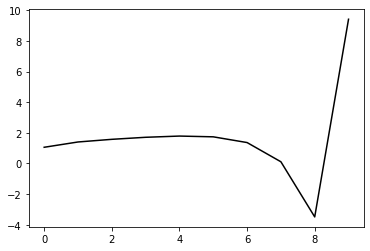

27000 0.20392800958188392
0.3167483414706157 -0.2839011987189982 0.17824616903809057 0.1161587031773697
[ 1.0830448   1.38033412  1.53770664  1.66072789  1.73136134  1.67657308
  1.30083739  0.04881435 -3.52631096  9.38279984]


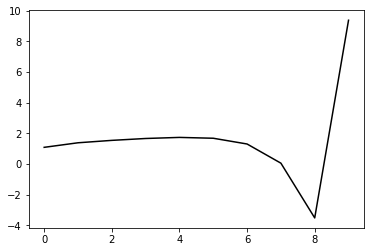

28000 0.17219303480636558
0.30928940576265296 -0.27922912208514156 0.17486598811114076 0.1205215295160937
[ 1.12052673  1.19044762  1.34787543  1.46885504  1.52272146  1.4513574
  1.06566918 -0.18803219 -3.73728581  9.41089086]


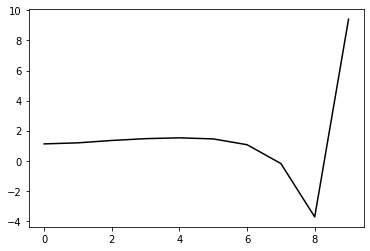

29000 0.22373171704866837
0.3069879239129611 -0.28198730792254767 0.17983154061492687 0.11853795128975789
[ 1.12367847  1.20864002  1.37266457  1.50971634  1.59004952  1.53633234
  1.16122778 -0.08382072 -3.61055275  9.36013993]


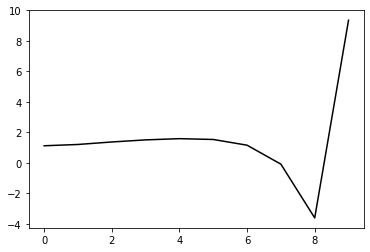

30000 0.2227312103537585
0.3150064020346509 -0.2710845159609148 0.1773695813815717 0.11843523538949209
[ 1.07309166  1.30855665  1.46910123  1.59553756  1.67285335  1.62289227
  1.25066944  0.00990259 -3.4938789   9.40727796]


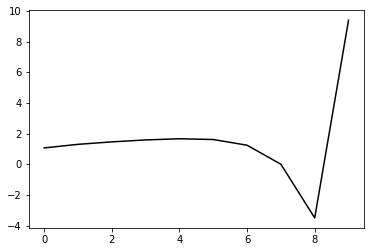

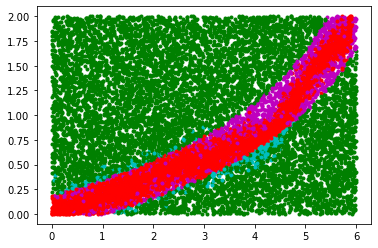

31000 0.33242159020518514
0.31567550444950393 -0.2655614888640666 0.17808426801656219 0.11422866172995887
[ 1.01691274e+00  1.30869721e+00  1.46471042e+00  1.59562394e+00
  1.67211685e+00  1.62052833e+00  1.24538513e+00  8.62181903e-04
 -3.49072938e+00  9.38317973e+00]


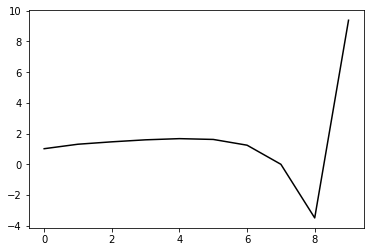

32000 0.19080901580360146
0.3079885435038716 -0.2661084006412515 0.17843548940189125 0.11892589443428277
[ 1.10640167  1.30556945  1.44814788  1.56597036  1.63704984  1.58573312
  1.21417411 -0.02356171 -3.48956489  9.38111251]


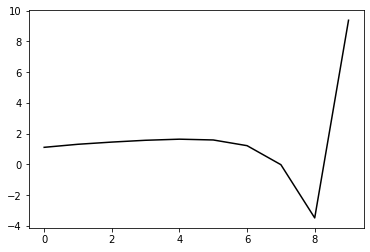

33000 0.15781471285967574
0.30491360415605706 -0.2657782128171528 0.18045578831090822 0.12056788714992936
[ 1.07010526  1.28800049  1.44290957  1.57987793  1.66778629  1.63336155
  1.27978584  0.06130201 -3.36610208  9.37854795]


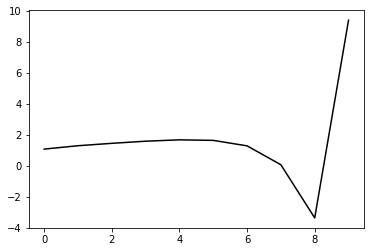

34000 0.3210471456625513
0.30626803998930113 -0.2597836908674983 0.18205686974528965 0.11519439039887013
[ 1.03025615  1.23529049  1.36941295  1.48898594  1.57181646  1.53573795
  1.18057465 -0.04077584 -3.46046335  9.37435198]


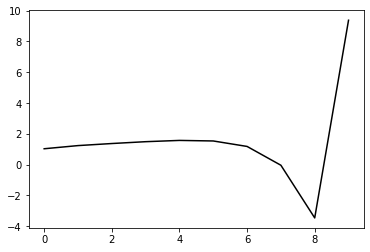

35000 0.14993926097319926
0.30177425314256384 -0.2595555303559823 0.18435832783557268 0.11974994325415553
[ 1.08933983  1.40866741  1.53457526  1.64641785  1.72580578  1.69227852
  1.34186842  0.12581733 -3.27658864  9.39423593]


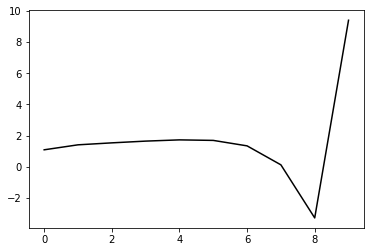

36000 0.2127862976527914
0.30195048812923697 -0.2503932201453747 0.18211386422623 0.1166296327496737
[ 1.07738929  1.33651591  1.49924664  1.6082915   1.66219062  1.60479483
  1.23860604  0.01162292 -3.38855113  9.38640852]


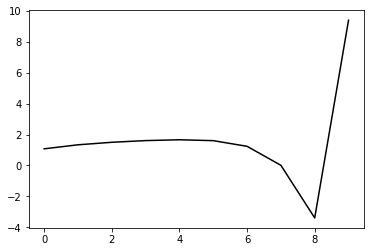

37000 0.22052292805908044
0.2991490003293162 -0.24971405362248222 0.1838251217069011 0.11854197567803693
[ 1.06726646  1.36883118  1.53737081  1.655264    1.71184495  1.64805167
  1.27633306  0.04739057 -3.34315992  9.38609115]


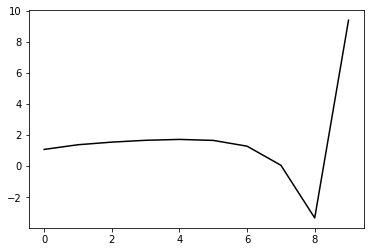

38000 0.3766611903856756
0.29946712800802133 -0.2460372514279851 0.1849181637266422 0.11759244971338485
[ 1.02474269  1.42193323  1.5717748   1.68336468  1.7387369   1.66911175
  1.29041375  0.0584642  -3.32257103  9.35430792]


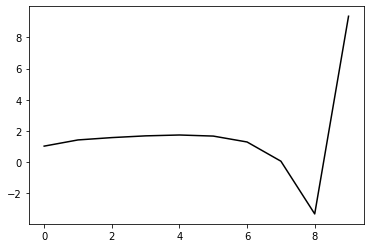

39000 0.2004071257437429
0.2930382922078925 -0.24886546973371662 0.18794297825218123 0.12029180183029982
[ 1.08299262  1.36608932  1.4969665   1.61345671  1.68127738  1.62459491
  1.25696902  0.03958666 -3.30996035  9.39556322]


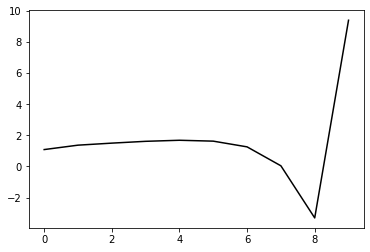

40000 0.14979648144630314
0.28825308814870476 -0.23967324323669034 0.183903221096541 0.11867564572186391
[ 1.10917328  1.27674427  1.43842657  1.56260025  1.63024259  1.5730678
  1.20320635 -0.01400758 -3.34854484  9.38305593]


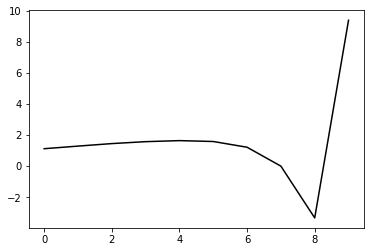

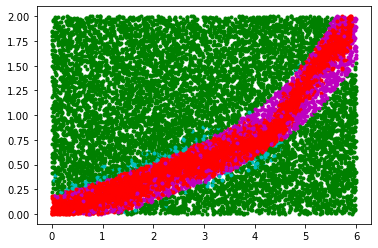

41000 0.2843533187822358
0.29344092847240827 -0.23485437358595543 0.18497588910530696 0.11682376897659538
[ 1.06134695  1.32485642  1.46162309  1.56429473  1.6163132   1.54454666
  1.16143424 -0.06491457 -3.39422396  9.38778943]


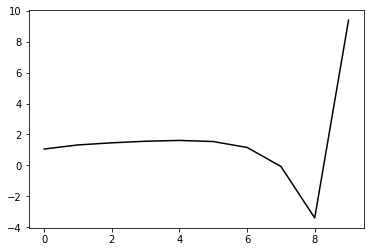

42000 0.17664977244298438
0.2916133857695454 -0.23666680607917503 0.186937638613842 0.11852064459563555
[ 1.08516213  1.32518283  1.47927738  1.59647636  1.66125194  1.60089653
  1.22745454  0.01248032 -3.29004025  9.38642319]


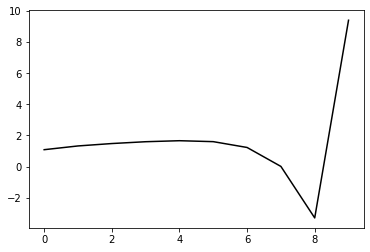

43000 0.22634779864483007
0.2936649876911876 -0.23255709107442493 0.18773667672676106 0.11994090638603375
[ 1.08948574  1.35932963  1.52119991  1.64322507  1.71113794  1.65406766
  1.28299487  0.07135524 -3.21532899  9.3740221 ]


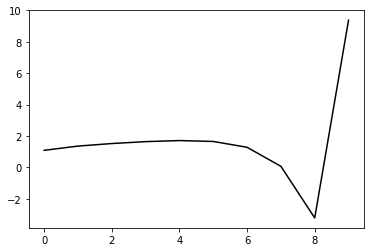

44000 0.41621115651540036
0.2944539911725062 -0.23406392899753892 0.1907642790083205 0.12016458277803854
[ 1.02490161  1.29300109  1.43088126  1.51057908  1.53831892  1.44771181
  1.05101713 -0.17711432 -3.46146372  9.37745839]


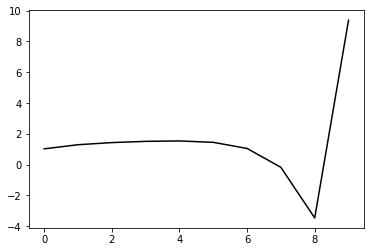

45000 0.17393512929499316
0.29688465447339485 -0.22929140370396245 0.1893128020331127 0.1215633241030249
[ 1.05433435  1.31759636  1.46662915  1.56890977  1.59958571  1.50126359
  1.09871349 -0.12885649 -3.39437632  9.38740547]


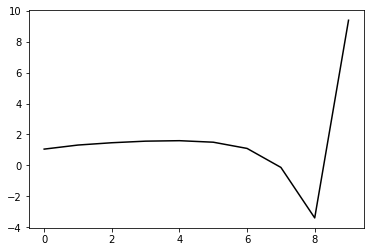

46000 0.29200134276335
0.28671924786756836 -0.23418757550373298 0.1936164481586752 0.11995716958967952
[ 1.10748456  1.13638869  1.252808    1.3713528   1.43003559  1.35103943
  0.958849   -0.25874347 -3.50144523  9.39306374]


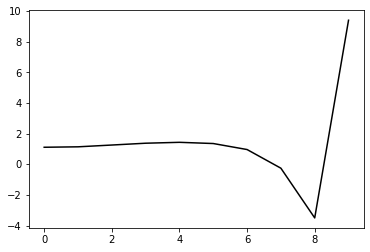

47000 0.2155663535806908
0.28345298705245137 -0.2259376577858415 0.18883887189958545 0.1257030693436466
[ 1.10171739  0.98727708  1.09245185  1.20083232  1.271478    1.2142971
  0.83944535 -0.36192535 -3.57490226  9.38798383]


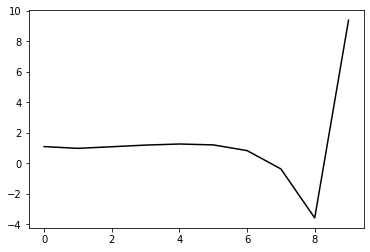

48000 0.19320199468711743
0.29257642948069235 -0.2223915179049597 0.19125401797759425 0.12558482064389861
[ 1.08181963  1.15626458  1.24591239  1.32755362  1.37017815  1.29450398
  0.90383835 -0.31365145 -3.53510226  9.39517   ]


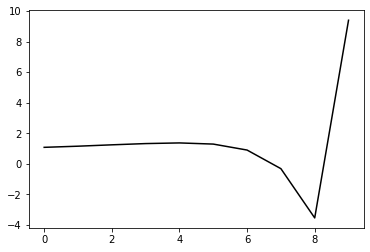

49000 0.18623300607508536
0.2991452618028451 -0.22701373652675283 0.1988824921536422 0.12120281876645618
[ 1.10172926  1.22777164  1.34045765  1.4087253   1.42424144  1.32486041
  0.91810775 -0.31118573 -3.53092856  9.37239022]


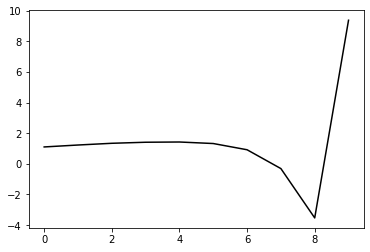

50000 0.3216813627647919
0.30659516542046206 -0.2147954300703305 0.19532078981096 0.12031749309785479
[ 1.03502787  1.35291863  1.50888535  1.60838203  1.62910483  1.51796026
  1.09709443 -0.14720679 -3.37721708  9.37387972]


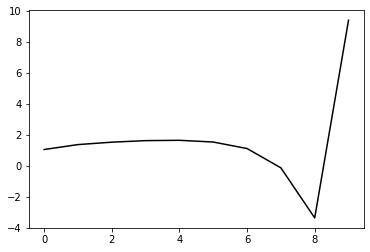

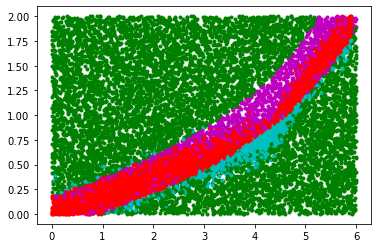

51000 0.22925181536069839
0.29328081295939895 -0.22156949956628474 0.198821905641625 0.12070275046523053
[ 1.0988377   1.21236501  1.33103145  1.42362683  1.45517334  1.35120626
  0.93458109 -0.30218777 -3.50959773  9.34501939]


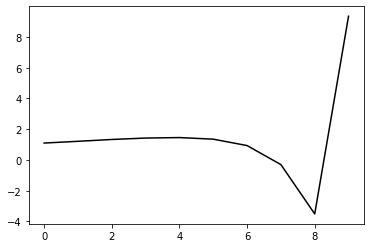

52000 0.1955958349678706
0.2915980953404521 -0.21414123783654146 0.19585010652930274 0.12629418768821063
[ 1.0724371   1.28913906  1.43694751  1.5415545   1.57962826  1.47774027
  1.0551456  -0.19176244 -3.40550317  9.3842276 ]


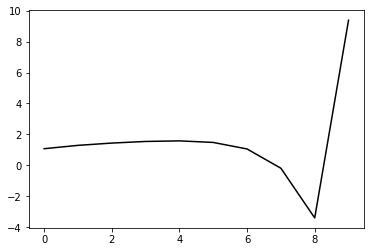

53000 0.26963797969394787
0.2876099109523429 -0.21365891036250168 0.1979006159453738 0.12242985534922471
[ 1.08510548  1.30207593  1.45572332  1.56489308  1.60522599  1.50372253
  1.07730409 -0.17502254 -3.38493745  9.36512311]


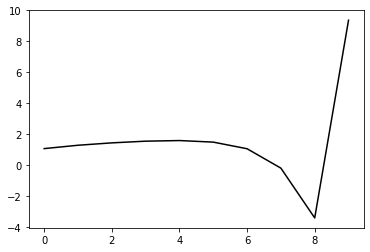

54000 0.2327739687835488
0.2913276907190739 -0.20555679757708573 0.197136722173712 0.11896004000208092
[ 1.0452141   1.30989057  1.44912534  1.54676798  1.58365136  1.48088545
  1.05145991 -0.20511336 -3.41014283  9.4078327 ]


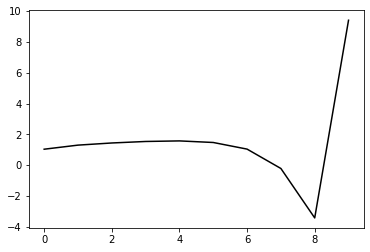

55000 0.25916822787559274
0.2841351068314468 -0.20788954705680693 0.1991613375146758 0.12192064560622155
[ 1.10354982  1.33987013  1.46591493  1.56684497  1.61246547  1.51870658
  1.09462549 -0.160002   -3.35467488  9.38114733]


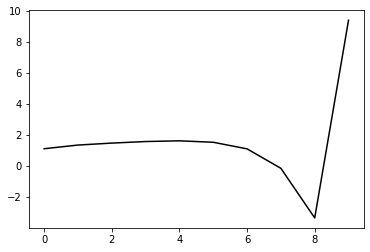

56000 0.24884115888692945
0.28557315958625423 -0.20464077221927263 0.19947210662581244 0.12254281364505344
[ 1.06839621  1.38839003  1.54069901  1.64868883  1.69454897  1.60386342
  1.18403863 -0.06655085 -3.2450812   9.38147432]


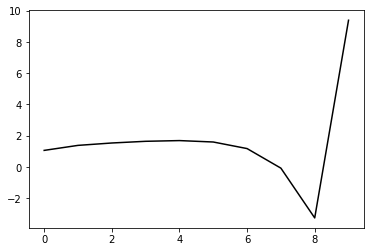

57000 0.21699557917021473
0.28137717087749453 -0.2022392911465544 0.19904627962870075 0.12388419072069358
[ 1.07139836  1.36906988  1.51115325  1.61222494  1.64803163  1.54514456
  1.11394901 -0.14795357 -3.3297617   9.39364214]


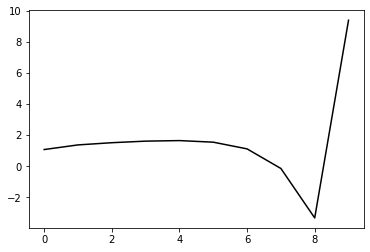

58000 0.2656771397679878
0.280281039009387 -0.20254004781492937 0.20125646823568477 0.12260739036082409
[ 1.07542637  1.35395284  1.50307504  1.59794261  1.62243461  1.50687991
  1.0638678  -0.20915164 -3.39513275  9.38497982]


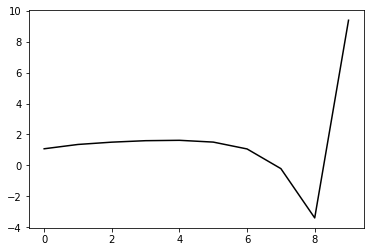

59000 0.2005151961596975
0.2827185135583599 -0.20187730033839443 0.2026472614986513 0.12563135698228584
[ 1.06954441  1.40343477  1.54817365  1.64513064  1.66679588  1.54510548
  1.09571095 -0.18242931 -3.36374504  9.39178583]


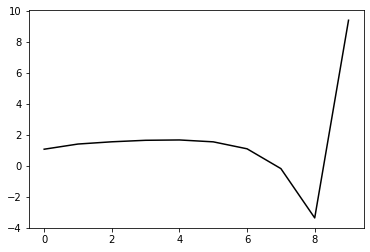

60000 0.2760280085145417
0.2803866968847981 -0.20531507504983562 0.20464764088708715 0.1275642884146734
[ 1.08529871  1.29149939  1.42249219  1.50941936  1.51940069  1.38431505
  0.92212697 -0.36524091 -3.54353499  9.3773311 ]


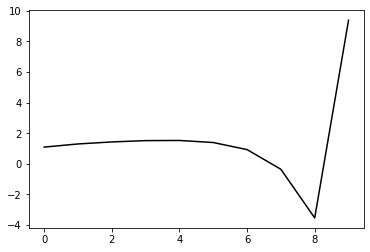

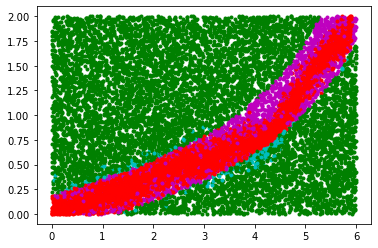

61000 0.2801893809080706
0.2825229141056742 -0.20078729613614424 0.2038487091079015 0.12960979932710195
[ 1.07844435  1.31754726  1.49843966  1.60937594  1.62706593  1.48923575
  1.01979792 -0.27457823 -3.4511422   9.37695867]


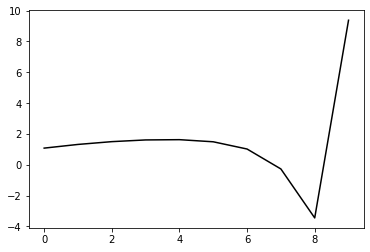

62000 0.1587396246592693
0.2816251744433532 -0.198349000832537 0.20332698506026028 0.12903354754206173
[ 1.06626103  1.29475503  1.43059085  1.54062655  1.57489329  1.44701626
  0.97945513 -0.31422321 -3.4795074   9.38084349]


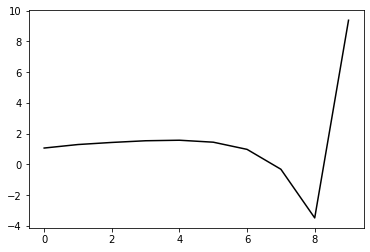

63000 0.19371528854501827
0.2808794537983695 -0.19459459614628888 0.2017139538923027 0.13181853332020282
[ 1.09607171  1.28339289  1.42065354  1.51416956  1.53974427  1.40932304
  0.93487794 -0.36868426 -3.53873283  9.36572271]


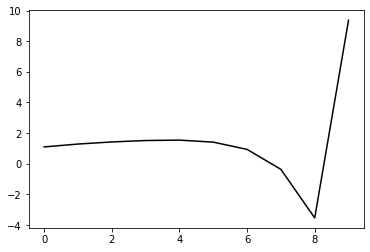

64000 0.16998485594868765
0.2814987054882623 -0.19297674772759646 0.20306229508193052 0.13199904399634405
[ 1.05306693  1.28149972  1.43961809  1.53928803  1.5617967   1.43103205
  0.95590521 -0.35005105 -3.5126558   9.36664924]


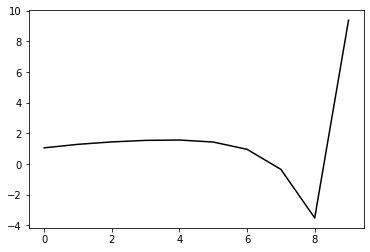

65000 0.2483562177837623
0.27776959260219986 -0.19004044800171951 0.20305498672407832 0.1319390268341657
[ 1.06332737  1.22789193  1.39026254  1.52030013  1.57573162  1.47205041
  1.01719939 -0.27642114 -3.42369991  9.37611792]


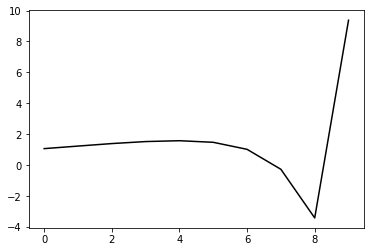

66000 0.2646252958255138
0.27595354556068474 -0.18907590156902396 0.20410322943564044 0.13385520538396214
[ 1.04609711  1.21913985  1.34151769  1.45095448  1.51049206  1.41869894
  0.97160666 -0.32082714 -3.463953    9.3455871 ]


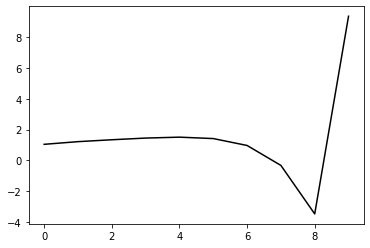

67000 0.20894936240797354
0.2773331936016332 -0.1846648685273926 0.20240563935442135 0.13427496130710617
[ 1.06161221  1.24103195  1.33692474  1.42171634  1.46719076  1.37786634
  0.93785395 -0.35121307 -3.48638233  9.37070297]


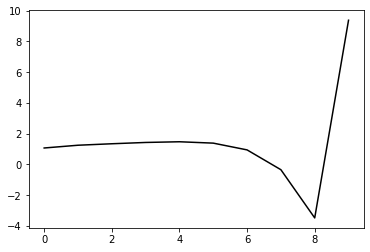

68000 0.18420800652815933
0.26796257353163544 -0.18905708463055873 0.2046281812758665 0.1367320485586821
[ 1.10023352  1.04313862  1.13126337  1.22257556  1.27893911  1.20813934
  0.79199051 -0.47809962 -3.59191647  9.37117224]


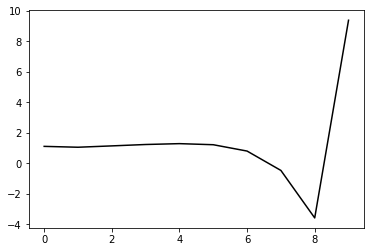

69000 0.2520844736280324
0.27738447243090714 -0.18787258581485525 0.2079180284866772 0.1339135301629141
[ 1.05431163  1.26608149  1.35980601  1.43484329  1.46973978  1.38370217
  0.96157368 -0.31319226 -3.42589078  9.34772844]


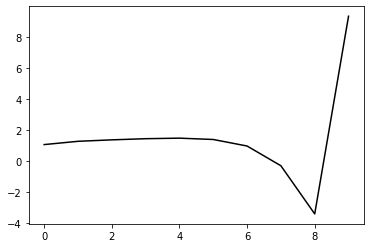

70000 0.2232590259401838
0.2700093526711272 -0.19002131028643152 0.20861817323057374 0.1347855370778564
[ 1.05488108  1.23365783  1.36736678  1.44614851  1.46733557  1.36715687
  0.93985419 -0.33726375 -3.4496764   9.32853681]


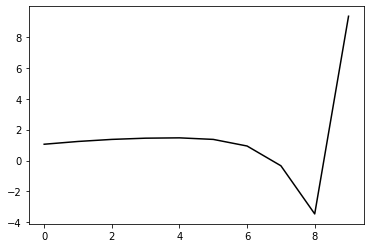

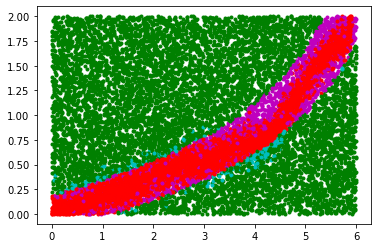

71000 0.15807963060295097
0.26780917432710133 -0.18600515208760768 0.209867538251469 0.13313268980704737
[ 1.05893427  1.26286678  1.38480865  1.48709764  1.53123754  1.44258333
  1.02459371 -0.24606197 -3.35751295  9.38479409]


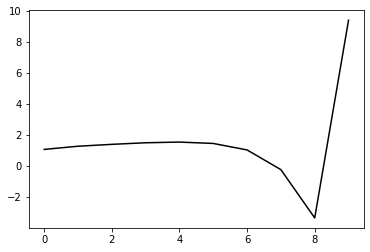

72000 0.11448346514900726
0.26849674373938953 -0.17849852748706738 0.2068770798391575 0.13081985623132356
[ 1.07747788  1.30587643  1.42221173  1.49907676  1.52016558  1.41241958
  0.97857873 -0.30400415 -3.42573695  9.36897597]


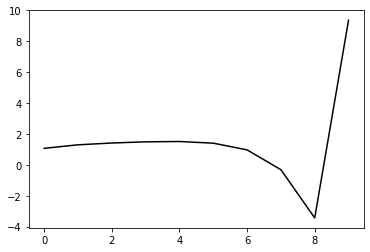

73000 0.2035798812799099
0.26700454182813743 -0.18186274241949058 0.2104967882811716 0.1305453375378234
[ 1.07244733  1.26281988  1.38543482  1.48349835  1.52462062  1.4317891
  1.01186069 -0.25431852 -3.35435005  9.34406089]


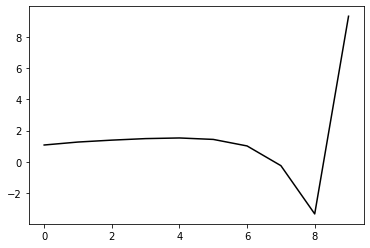

74000 0.3379832757710096
0.2708591032554743 -0.17813232160952203 0.21069144101363968 0.12968382352111577
[ 1.00795575  1.36807338  1.51422574  1.60368246  1.63257476  1.53090411
  1.10469821 -0.1635516  -3.26154125  9.39111933]


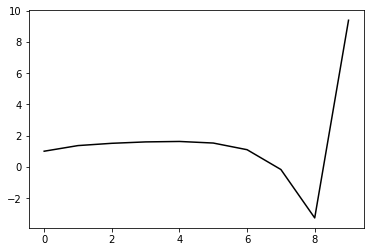

75000 0.1876952373739955
0.2619350420288847 -0.17887642700179646 0.21020645006254146 0.13024006037816308
[ 1.06497677  1.28833918  1.42334443  1.51874514  1.5446511   1.43440731
  1.0027378  -0.26312172 -3.3473767   9.38207999]


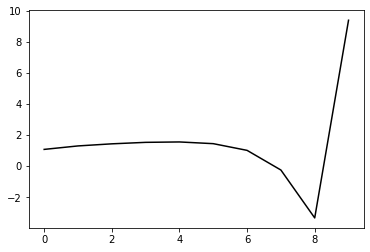

76000 0.19937229556614194
0.255010262649541 -0.18153061711203888 0.21098923391100669 0.12971917963720678
[ 1.08230332  1.17807264  1.28393785  1.36714431  1.38849042  1.2714606
  0.83044551 -0.44138623 -3.52587832  9.37343452]


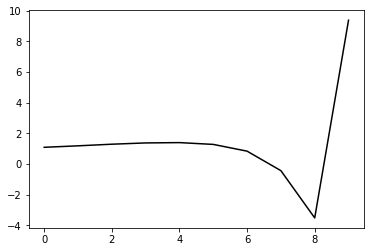

77000 0.22066691599402263
0.26337309751519994 -0.17954714935818686 0.21247657248838636 0.1310361122683227
[ 1.06427345  1.25699249  1.39449843  1.49704564  1.52600602  1.41120639
  0.96886574 -0.30307029 -3.382705    9.39206838]


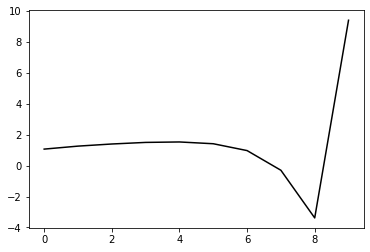

78000 0.2087759826105858
0.26036379077431165 -0.17968595572803545 0.21388909787906676 0.1279710048063066
[ 1.06905504  1.25164443  1.38888101  1.47771279  1.50050174  1.37966762
  0.92922152 -0.34899619 -3.42949323  9.40464254]


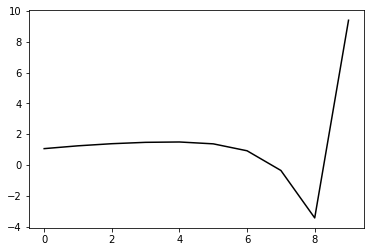

79000 0.21978757753038827
0.2664309819787306 -0.1759841507157861 0.21321142266285417 0.13040211042186906
[ 1.04546315  1.29175006  1.4444496   1.54174097  1.56700174  1.44996205
  1.00321903 -0.26943062 -3.33721964  9.38205095]


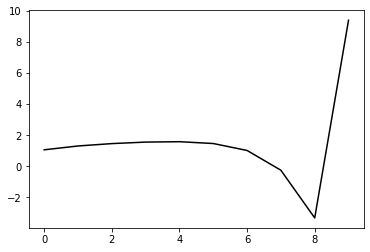

80000 0.17212130809319118
0.26081807161008685 -0.18092881332304112 0.2159813947565576 0.1316666662233866
[ 1.1162135   1.12813078  1.24016137  1.32749807  1.3581015   1.246911
  0.80445405 -0.46357633 -3.52165325  9.37110312]


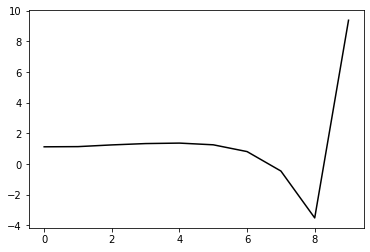

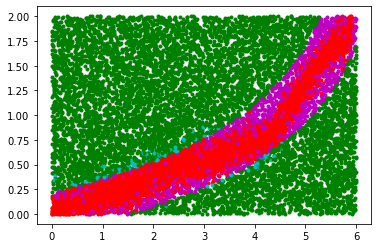

81000 0.2757883485971353
0.2643253293732133 -0.18059608457083967 0.21670621089556036 0.1317155144268688
[ 1.06054125  1.14748014  1.27784205  1.35710629  1.36668938  1.23803892
  0.78080408 -0.49948142 -3.56368066  9.34135456]


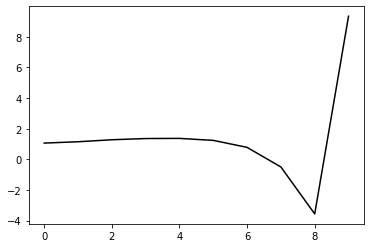

82000 0.2134034138946264
0.266577389932169 -0.17597591761577736 0.21511837587295704 0.13482817869943436
[ 1.0548996   1.25363891  1.40022149  1.49272147  1.50489401  1.37065691
  0.90613281 -0.38168311 -3.45099753  9.38493225]


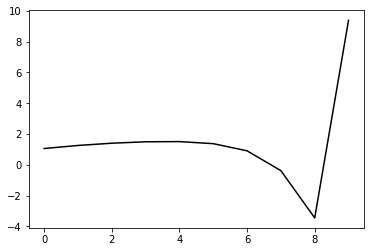

83000 0.23636749884962305
0.26896586101284076 -0.17114662085437982 0.21445131013227994 0.13557500442511564
[ 1.01456712  1.32006258  1.4680648   1.58654364  1.62987791  1.51843697
  1.06921069 -0.20632458 -3.2604062   9.34576176]


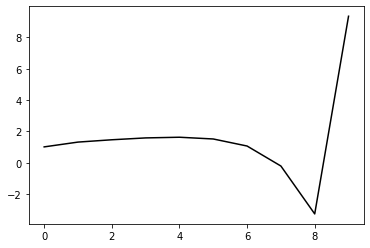

84000 0.2811414600513705
0.2619932725405024 -0.1734056278546899 0.21747300641665707 0.13235544360350057
[ 1.03231817  1.25882312  1.39820763  1.52883508  1.60638283  1.53080926
  1.10484265 -0.15975584 -3.21038959  9.4328284 ]


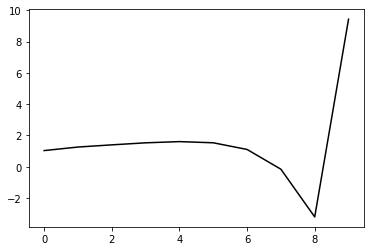

85000 0.45839796960454804
0.2638978081637202 -0.1697042695135982 0.2164936770064448 0.13113037643947867
[ 0.99281703  1.34802259  1.489825    1.58931443  1.64117579  1.5561176
  1.12485262 -0.14627906 -3.19863781  9.34854102]


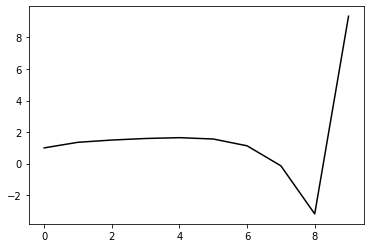

86000 0.24767717275683093
0.25871206109012373 -0.1674066669181408 0.2142902567163771 0.1329364453364207
[ 1.01797212  1.28540784  1.4020016   1.47898236  1.50847127  1.40755594
  0.96865011 -0.30940834 -3.36513799  9.37352093]


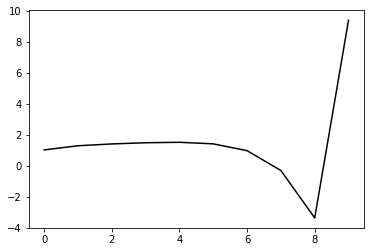

87000 0.13824394254898906
0.25943224255635833 -0.16393616626229165 0.21263165040279544 0.13269742207869545
[ 1.0311938   1.3276722   1.4503193   1.52942547  1.53963559  1.41663844
  0.96281292 -0.32731983 -3.39126578  9.41262894]


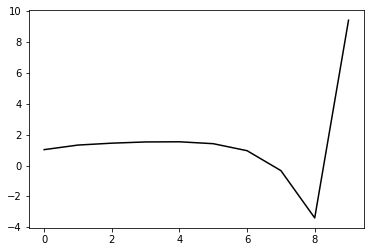

88000 0.29073749334055776
0.25731736811730227 -0.16978351113435755 0.2183192123705581 0.1316635740581825
[ 1.02589249  1.27218699  1.39619756  1.48815622  1.51731763  1.40594201
  0.96331899 -0.31467856 -3.36375535  9.39031809]


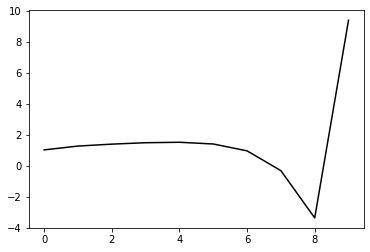

89000 0.22894917930987893
0.2515758329509193 -0.16962117174778232 0.21790677539431336 0.1308337947519643
[ 1.10464294  1.14391858  1.25524879  1.34716926  1.38192389  1.2765519
  0.8386922  -0.43373961 -3.4744497   9.35839579]


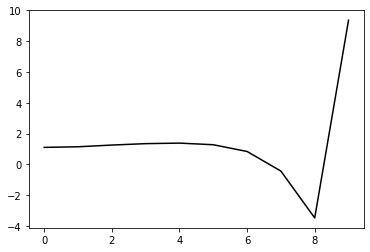

90000 0.20981110436117442
0.2552548104648451 -0.1684316251616793 0.21852122441155628 0.13284202653580907
[ 1.06054199  1.27816891  1.38637346  1.46167026  1.47368753  1.34966355
  0.89606723 -0.38893704 -3.43889313  9.38468997]


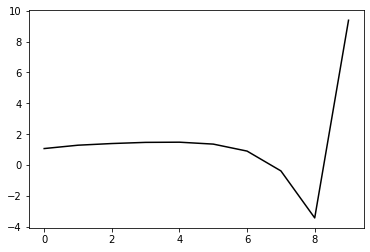

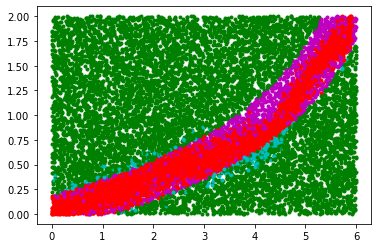

91000 0.17712617526037963
0.25437100613980146 -0.16361661900248903 0.21678855988203585 0.1339001855941338
[ 1.04672028  1.26549395  1.39357934  1.47077232  1.48368697  1.35966858
  0.90731995 -0.37473679 -3.41993691  9.38434096]


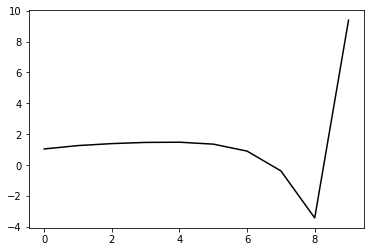

92000 0.14256735619646044
0.25804819754694336 -0.16079750214486688 0.2156593720262655 0.13230468427809672
[ 1.0787098   1.34204209  1.45991949  1.52990658  1.52817112  1.38704866
  0.91928233 -0.37480842 -3.42801705  9.42849549]


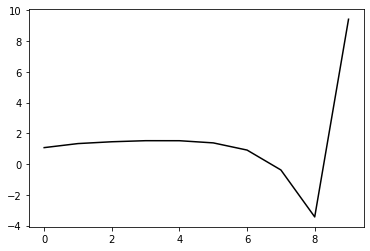

93000 0.2645107698007105
0.26114267303839017 -0.1588736419391193 0.2177314026567535 0.12873687818354623
[ 1.05013227  1.31853824  1.4468054   1.53129356  1.54384678  1.40831198
  0.94109413 -0.35408249 -3.41017513  9.38027886]


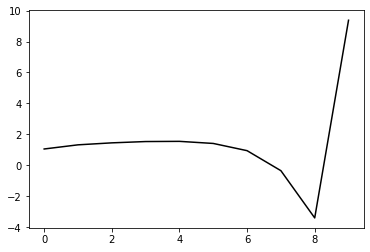

94000 0.15981318842725642
0.2577521250186417 -0.15966634424861512 0.21613997807766727 0.135489185376035
[ 1.05205939  1.26356544  1.41640209  1.50822175  1.51900015  1.38135263
  0.91068562 -0.38520025 -3.43523167  9.32936905]


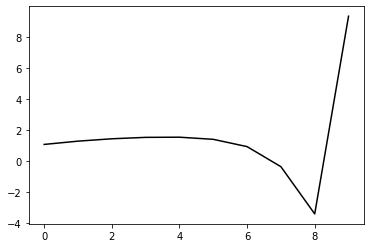

95000 0.1749884171079017
0.25218754562418494 -0.16705635566900368 0.2208764824304896 0.13759958476844755
[ 1.05520754  1.24822017  1.39503344  1.50717018  1.54284421  1.42618413
  0.97257099 -0.30516847 -3.3283637   9.37512066]


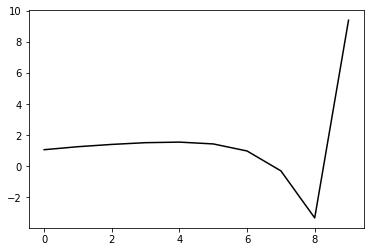

96000 0.3130728594182591
0.2578146464324126 -0.16314920390788357 0.21990167629981633 0.13537462141818846
[ 1.01119378  1.29074841  1.41950662  1.49286179  1.5033178   1.36805202
  0.89741492 -0.39514168 -3.42896073  9.37460159]


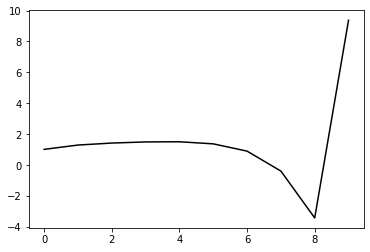

97000 0.18540237715636512
0.2567458429563753 -0.1647862717541204 0.22211906274196203 0.13360448063603714
[ 1.05619693  1.28481903  1.42379873  1.51502644  1.52951785  1.39653414
  0.92751777 -0.36468199 -3.39664248  9.37477159]


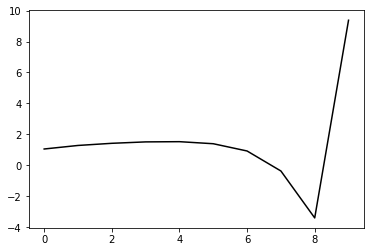

98000 0.3962247143667343
0.2604930143898174 -0.15954252123101606 0.2222511702838631 0.13212066888969712
[ 1.02452373  1.34562113  1.47175104  1.57923876  1.62108032  1.50913726
  1.05245228 -0.23614767 -3.27230325  9.38909936]


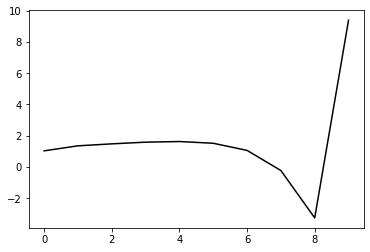

99000 0.36913227394797277
0.2590672119463258 -0.15707055280242616 0.22155323911520186 0.13266974939860982
[ 0.99050388  1.33816982  1.46437144  1.56661031  1.61568328  1.51926672
  1.07673769 -0.20091219 -3.22443954  9.36981837]


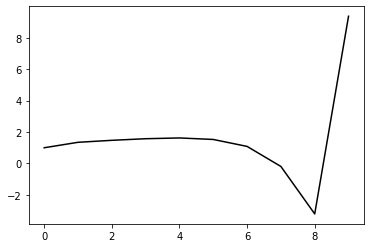

In [22]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

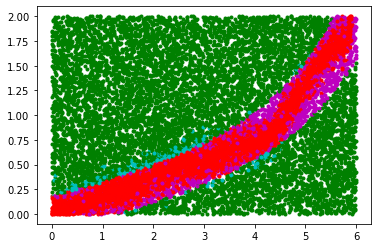

In [23]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]        
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()